# Análisis predictivo: Clustering y clasificación

## Índice

 1. [Introducción](#introduccion)
    - [Objetivos del análisis](#objetivos)
 2. [Descripción de los datos](#descripcion-datos)
 3. [Preparando el ambiente](#preparando-ambiente)
    - [Imports](#imports)
    - [Datasets](#datasets)
    - [Columnas e indicadores](#columnas-indicadores)
 4. [Clustering](#clustering)
    - [JJ.OO. de Verano](#clustering-verano)
    - [JJ.OO. de Invierno](#clustering-invierno)
    - [Categorías](#clustering-categorias)
 5. [Visualización: Categorías en mapamundi](#visualizacion)
    - [Categoría 0](#visualizacion-0)
    - [Categoría 1](#visualizacion-1)
    - [Categoría 2](#visualizacion-2)
    - [Categoría 3](#visualizacion-3)
 6. [Clasificación con factores externos](#clasificacion)
    - [Elección de indicadores](#eleccion-indicadores)
    - [Un poco más de tratamiento](#mas-tratamiento)
    - [Regresión logística](#regresion-logistica)
    - [Árbol de decisión](#arbol-decision)

## Introducción <a name="introduccion"></a>

El presente proyecto es una continuación de proyecto global llamado OlympicMedalsByCountry. El proyecto ha estado analizando el desempeño olímpico de cada país usando un dataset que contiene la cantidad total de medallas de los tres metales obtenidas por país, a lo largo de la historia. Ya hecho un [análisis estadístico básico](01-Analisis_estadistico_descriptivo.ipynb), es turno de continuar con otro análisis, esta vez auxiliado con herramientas de *Machine Learning*.

Este análisis se llevará a cabo considerando por separado las ediciones de los Juegos Olímpicos (JJ.OO) de Verano e Invierno. Para cada edición, se realizarán dos agrupaciones: una basada en el número de participaciones y otra en la cantidad de medallas de oro, plata y bronce obtenidas. En total, se desarrollarán cuatro tipos de agrupaciones diferentes, utilizando técnicas de clustering para identificar clases representativas en cada caso.

Las cuatro agrupaciones resultantes, junto con sus respectivas clases representativas, se analizarán mediante técnicas de clasificación utilizando factores externos específicos de cada país. El objetivo es identificar patrones, si los hubiere, entre las clases generadas y los factores socioeconómicos. Se emplearán tanto la Regresión Logística como los Árboles de Decisión para experimentar con ambos modelos y determinar cuál ofrece el mejor rendimiento.

### Objetivos del análisis <a name="objetivos"></a>
 * Identificar patrones entre las diferentes agrupaciones y factores com la posición geográfica, el PIB, la corrupción, la salud, y otros indicadores.

## Descripción de los datos <a name="descripcion-datos"></a>

Los datasets que serán usados para este estudio serán [olympics.csv](data/olympics.csv) y [info_countries.csv](data/info_countries.csv), que están alojados en el directorio `data/`. Estos datasets contienen información del total de medallas ganadas y los promedios de los indicadores de interés de cada país, respectivamente. Los datasets se han extraído de diversas fuentes, y los detalles de este proceso están descritos en el notebook numerado con [00](00-Tratamiento_de_Datos.ipynb).

Los detalles de los datasets que usarán en este notebook podrán ser encontrados en [01-Analisis_estadistico_descriptivo.ipynb](01-Analisis_estadistico_descriptivo.ipynb), que es el encargado de realizar toda la estadística básica y un estudio de correlación.

## Preparando el ambiente <a name="preparando-ambiente"></a>

### Imports <a name="imports"></a>

El proyecto fue desarrollado usando **Python 3.8.10**. Y los requerimientos exactos, que pueden instarse usando el archivo [requirements.txt](requirements.txt), son los siguientes,

 - countryinfo==0.1.2
 - geopandas==0.13.2
 - googletrans==4.0.0rc1
 - matplotlib==3.7.1
 - numpy==1.22.3
 - pandas==1.4.3
 - pycountry==24.6.1
 - requests==2.31.0
 - scikit_learn==1.3.0
 - seaborn==0.12.2
 - Unidecode==1.1.1
 - beautifulsoup4==4.12.2
 - html5lib==1.1
 - lxml==4.9.3
 - fiona==1.9.6

Los imports básicos que se usarán serán los siguientes,

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Además, para el clustering usaremos el algoritmo K-means, que el módulo scikit-learn tiene disponible,

In [2]:
from sklearn.cluster import KMeans

Por otro lado, se realizará una visualización de los clusters obtenidos en mapamundis, por lo que necesitaremos de Geopandas para manipular datos geográficos,

In [3]:
import geopandas as gpd

Y por último, usaremos varios objetos de scikit-learn para crear y evaluar los modelos de clasificación que se usarán, así como el procesamiento de datos para elevar el desempeño de estos,

In [4]:
import warnings

from sklearn.exceptions import FitFailedWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Datasets <a name="datasets"></a>

La herramienta principal que se usarán serán los dataframes ofrecidos por el módulo Pandas. Los datasets se importarán como dataframes y así se podrá trabajar de manera más cómoda con los datos. Sin embargo, a diferencia del análisis descriptivo hecho anteriormente, en este caso ambos datasets serán alojados en el mismo dataframe desde un inicio.

In [5]:
def importar_dataframe():
	df_medallas = pd.read_csv("data/olympics.csv")
	df_medallas = df_medallas.dropna(subset="ISO_code")
	df_countries = pd.read_csv("data/info_countries.csv")

	return df_medallas.merge(df_countries, how="inner", on="ISO_code")

df = importar_dataframe()
df.head()

,Country,Country_name,Country_code_coi,ISO_code,Continente_x,Num_Summer,gold_summer,silver_summer,bronze_summer,Total_summer,...,Food_insecurity_media,GDP_per_capita_growth_media,GDP_per_capita_media,Health_expenditure_per_capita_media,Prevalence_of_undernourishment_media,Primary_completion_rate_media,Research_dev_expenditure_media,Vulnerable_employment_media,population_media,surface_area_media
0,Afghanistan (AFG),Afghanistan,AFG,AFG,Asia,16,0,0,2,2,...,19.328571,1.152146,416.667609,49.495439,27.938095,45.264939,NaN,88.861321,1.878244e+07,6.528600e+05
1,Albania (ALB),Albania,ALB,ALB,Europa,10,0,0,2,2,...,9.357143,2.946025,2704.306845,238.629357,5.666667,103.522464,0.120845,58.076484,2.713609e+06,2.875000e+04
2,Algeria (ALG),Algeria,ALG,DZA,África,15,7,4,9,20,...,9.300000,1.312632,2428.841080,201.586538,4.461905,83.105215,0.259473,29.516741,2.622281e+07,2.381740e+06
3,Argentina (ARG),Argentina,ARG,ARG,América,26,22,27,31,80,...,11.028571,0.995601,7948.212149,899.976744,3.395238,96.703933,0.495866,22.096759,3.320280e+07,2.780400e+06
4,Armenia (ARM),Armenia,ARM,ARM,Europa,8,2,11,9,22,...,0.620000,4.450079,2545.232810,281.954545,7.395238,96.017295,0.233435,65.218353,2.927306e+06,2.974000e+04


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 0 to 141
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               142 non-null    object 
 1   Country_name                          142 non-null    object 
 2   Country_code_coi                      142 non-null    object 
 3   ISO_code                              142 non-null    object 
 4   Continente_x                          142 non-null    object 
 5   Num_Summer                            142 non-null    int64  
 6   gold_summer                           142 non-null    int64  
 7   silver_summer                         142 non-null    int64  
 8   bronze_summer                         142 non-null    int64  
 9   Total_summer                          142 non-null    int64  
 10  Num_Winter                            142 non-null    int64  
 11  gold_winter        

El dataframe, llamado simplemente como `df`, cuenta con 142 registros, los cuales son los más esenciales para el análisis que realizaremos.

### Columnas e indicadores <a name="columnas-indicadores"></a>

A modo de agilizar y simplificar el código, también vamos a definir una serie de variables y listas que nos ayudarán más adelante a elegir los grupos de columnas de interés que usaremos en los análisis posteriores. Primero vamos a definir las correspondientes a los JJ.OO. de Verano,

In [7]:
# Numero de participaciones en los JJ.OO. de Verano
num_summer = ["Num_Summer"]

# Numero de medallas ganadas en los tres metales
medals_summer = ["gold_summer", "silver_summer", "bronze_summer"]

y luego las columnas correspondientes a los JJ.OO. de Invierno,

In [8]:
num_winter = ["Num_Winter"]
medals_winter = ["gold_winter", "silver_winter", "bronze_winter"]

Luego, definamos la lista de indicadores a utilizar. Los indicadores que usaremos aquí se ha seleccionado usando de base el análisis de correlación realizado en el Análisis Estadístico descriptivo. Solo se seleccionaron aquellos que obtuvieron una Correlación Débil o mayor en alguno de los parámetros olímpicos,

In [9]:
indicadores = [
	"latitude",
	"Access_to_electricity_media",
	"AFFVA_media",
	"Cause_of_death_by_media",
	"Control_of_Corruption_media",
	"Expenditure_on_education_media",
	"GDP_per_capita_media",
	"Health_expenditure_per_capita_media",
	"Prevalence_of_undernourishment_media",
	"Primary_completion_rate_media",
	"population_media",
	"Research_dev_expenditure_media",
	"surface_area_media",
	"Vulnerable_employment_media"
]

Y por último crearemos otra lista con los datos más relevantes de cada país.

In [10]:
datos_pais = ["nombre", "ISO_code", "Short_Name"]

## Clustering <a name="clustering"></a>

Ahora comenzaremos con el clustering de los datos. Esto lo realizaremos, como ya habíamos mencionado, separando ambas ediciones de los JJ.OO., y en cada uno se realizarán dos diferentes clasificaciones: una para el número de participaciones y otra para las medallas ganadas. Todas las clasificaciones se realizarán usando el algoritmo de K-Means, por lo que es necesario usar un criterio adecuado para determinar el número de clusters a realizar.

In [11]:
def metodo_del_codo(data, columns, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    X = data[columns]

    # Calcular inertia para diferentes números de clusters
    inertia = []
    for k in range(1, 15):
        kmeans = KMeans(n_clusters=k, n_init="auto")
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Graficar la inertia
    ax.plot(range(1, 15), inertia, marker='o')
    ax.set_xlabel('Número de Clusters')
    ax.set_ylabel('Inertia')
    ax.set_title('Método del Codo', fontdict={"fontsize" : 16})
    plt.show()


La función anterior nos ayudará a graficar las inercias para diferentes cantidades de clusters, y así poder aplicar el Método del Codo para determinar el número óptico de clusters a utilizar en cada caso. También usaremos otra función más para visualizar los datos una vez hayan sido "clusterizados". Para construir esta función usaremos `pairplot` de Seaborn,

In [12]:
def graficar_clusters(data, columnas, clusters_columna, palette="pastel"):
	sns.pairplot(
		data=data[columnas + [clusters_columna]], hue=clusters_columna,
		corner=True, palette=palette
	)
	plt.show()

Y con las herramientas bien definas, ya estamos listos para realizar clustering a los datos. 

### JJ.OO. de Verano <a name="clustering-verano"></a>

Comencemos con el clustering de los parámetros de los JJ.OO. de Verano, específicamente con la columna de número de participaciones en esta edición. A pesar de que KMeans no se suele utilizar cuando $X$, los datos de entrada, es de una sola dimensión, se ha decidido que es lo que usará en esta ocasión. Vamos a aplicar el Método del Codo,

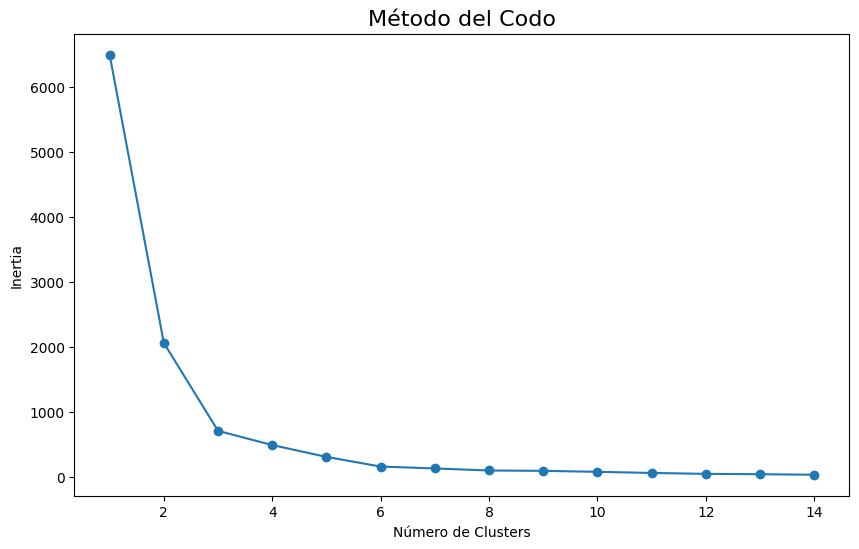

In [13]:
metodo_del_codo(data=df, columns=num_summer)

El cambio más abrupto que se puede observar es para 3 clústers, por lo que es el número que se usará. Procedamos el clustering,

In [14]:
kmeans_num_summer = KMeans(n_clusters=3, n_init="auto").fit(df[num_summer])
df["clusters_num_summer"] = kmeans_num_summer.labels_

Ordenamos las etiquetas de los clusters de menor a mayor dado el número de participaciones, 

In [15]:
mean_values = df.groupby(by="clusters_num_summer")[num_summer[0]].mean().sort_values()
df["clusters_num_summer"] = df["clusters_num_summer"].map(
	{old : new for new,old in enumerate(mean_values.index)}
)

Y procedamos con la visualización de los mismos. Como en este caso se "cluesterizó" con una sola columna, se usará `swarmplot` para visualizar la dispersión, en lugar de la función hecha anteriormente,

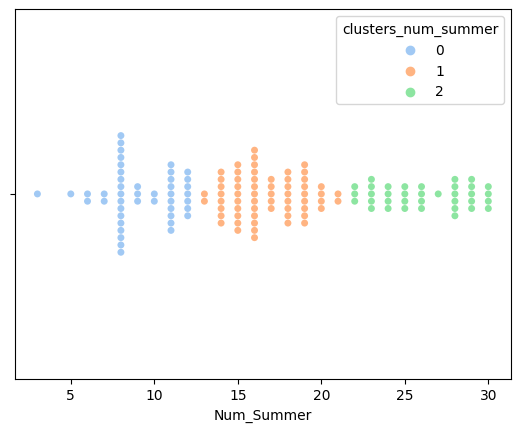

In [16]:
sns.swarmplot(df, x=num_summer[0], hue="clusters_num_summer", palette="pastel")
plt.show()

Ahora "clustericemos" el dataframe dadas las medallas ganadas en los tres metales. Antes que nada, echemos un vistazo a la distribución de los datos con un pairplot,

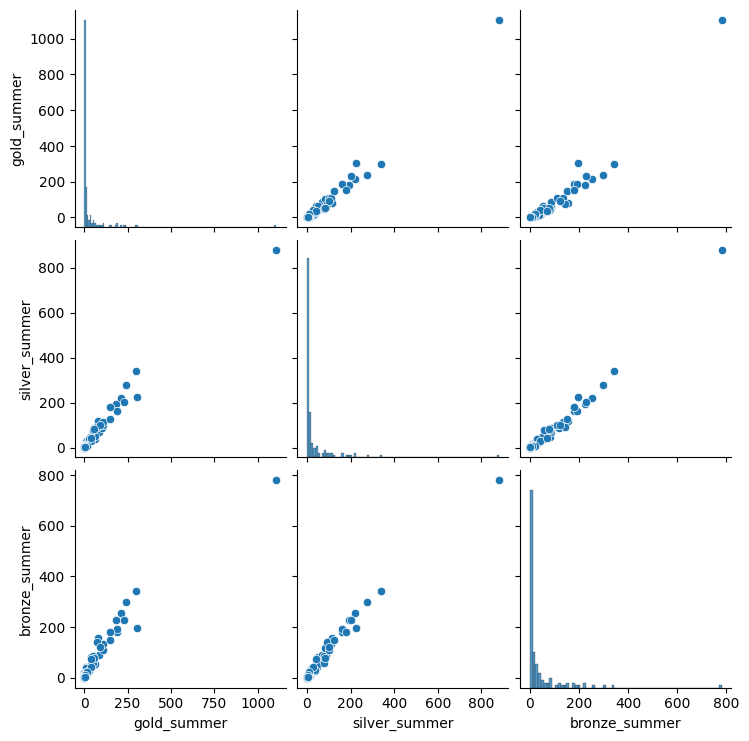

In [17]:
sns.pairplot(data=df[medals_summer])
plt.show()

Por lo que podemos observar, tenemos un valor muy extremo para las tres medallas. Como ya se había encontrado en notebooks anteriores, este valor extremo corresponde a los datos de las medallas ganadas por USA, que tiene una clara ventaja respecto a todos los demás países,

In [18]:
usa = df.query("ISO_code == 'USA'")
usa[datos_pais + medals_summer]

,nombre,ISO_code,Short_Name,gold_summer,silver_summer,bronze_summer
134,Estados Unidos,USA,United States,1105,879,780


Sin embargo, necesitamos eliminarlo para que K-Means trabaje de forma optima; el dato será devuelto después para realizar el estudio para las JJ.OO. de Invierno.

In [19]:
df = df.query("ISO_code != 'USA'")

Una vez hecho lo anterior, vamos a aplicar el Método del Codo,

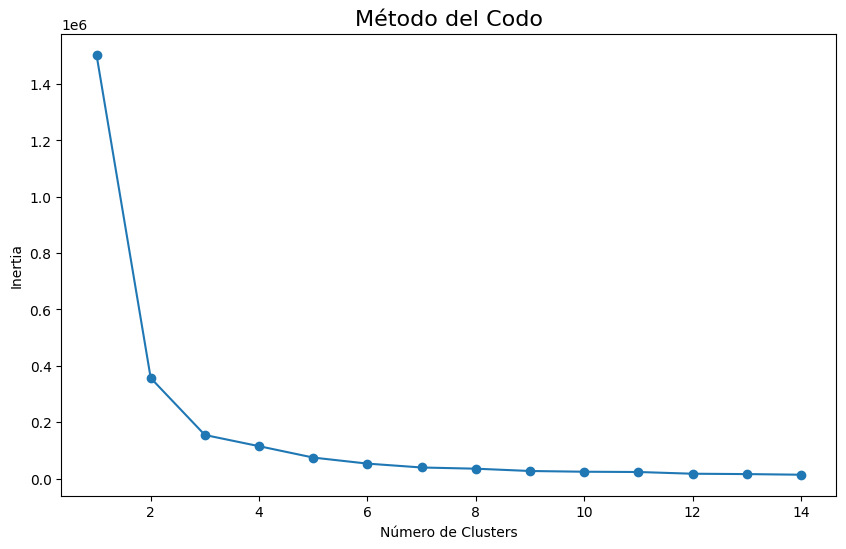

In [20]:
metodo_del_codo(data=df, columns=medals_summer)

Nuevamente usaremos 3 clústers para esta clasificación,

In [21]:
kmeans_medals_summer = KMeans(n_clusters=3, n_init="auto").fit(df[medals_summer])
df["clusters_medals_summer"] = kmeans_medals_summer.labels_

Ordenamos los clúster dada la distancia euclideana entre las tres medallas,

In [22]:
euclidean_distance = df.groupby(by="clusters_medals_summer")[medals_summer].apply(lambda x: np.linalg.norm(x.mean())).sort_values()
df["clusters_medals_summer"] = df["clusters_medals_summer"].map(
	{old : int(new) for new,old in enumerate(euclidean_distance.index)}
)

Y visualizamos los clústers obtenidos,

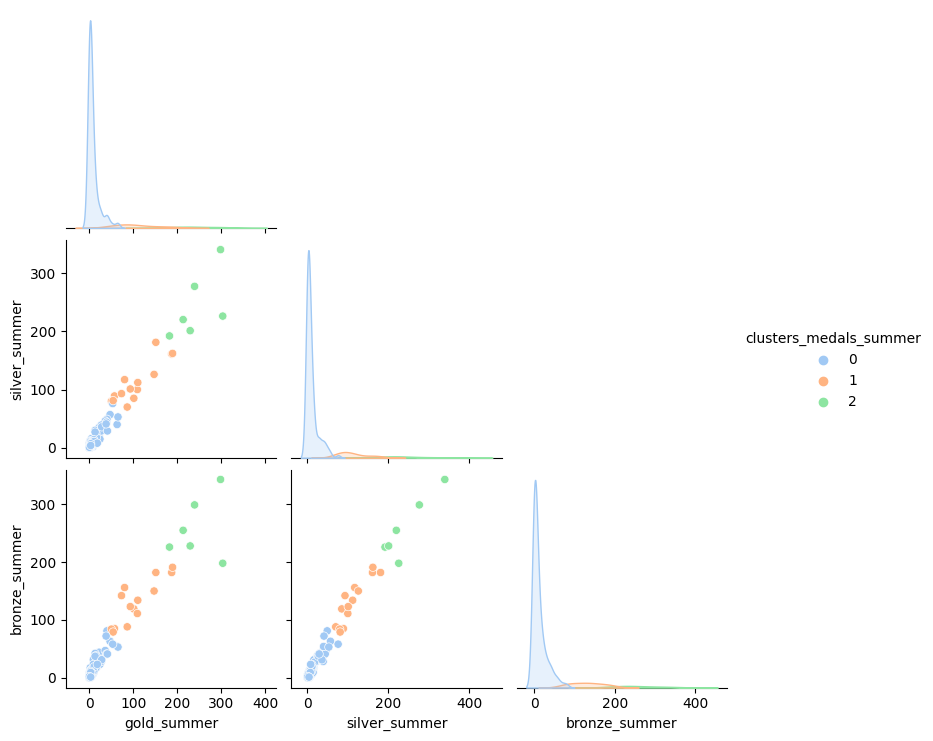

In [23]:
graficar_clusters(data=df, columnas=medals_summer, clusters_columna="clusters_medals_summer")

Como podemos observar, los clústers dividen los datos en zonas con claras diferencias de densidad. Esto es lo que se busca para un análisis posterior óptimo.

### JJ.OO. de Invierno <a name="clustering-invierno"></a>

Es turno de hacer los clústers para los parámetros de los JJ.OO. de Invierno. El proceso es el mismo que en el anterior, por lo que avanzaremos más rápido. Aunque antes de eso, no olvidemos volver a agregar a USA a los datos,

In [24]:
df = pd.concat([df, usa], ignore_index=True)
df = df.sort_values(by="ISO_code").reset_index(drop=True)

Comencemos con el Método del Codo para el número de participaciones,

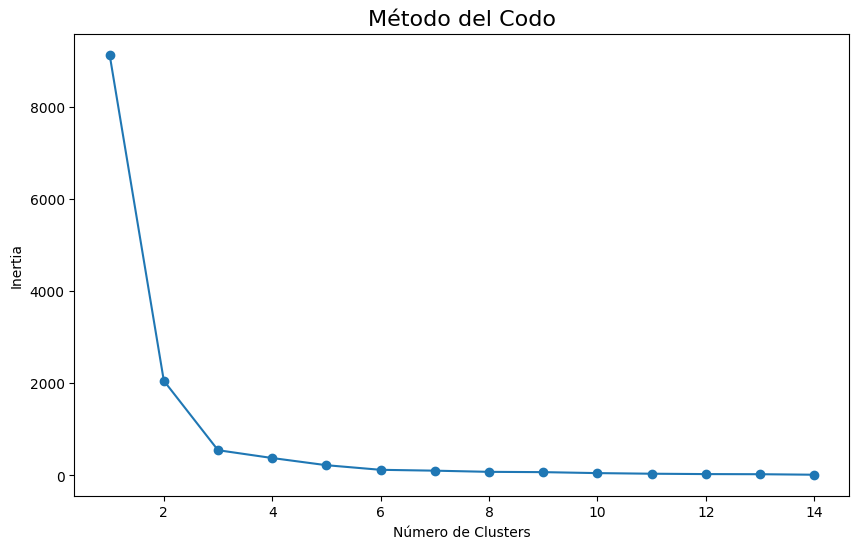

In [25]:
metodo_del_codo(data=df, columns=num_winter)

Nuevamente tendremos 3 clústers en este caso. Continuamos con KMeans,

In [26]:
kmeans_num_winter = KMeans(n_clusters=3, n_init="auto").fit(df[num_winter])
df["clusters_num_winter"] = kmeans_num_winter.labels_

Ordenamos los cústers,

In [27]:
mean_values = df.groupby(by="clusters_num_winter")[num_winter[0]].mean().sort_values()
df["clusters_num_winter"] = df["clusters_num_winter"].map(
	{old : new for new,old in enumerate(mean_values.index)}
)

Y visualizamos 

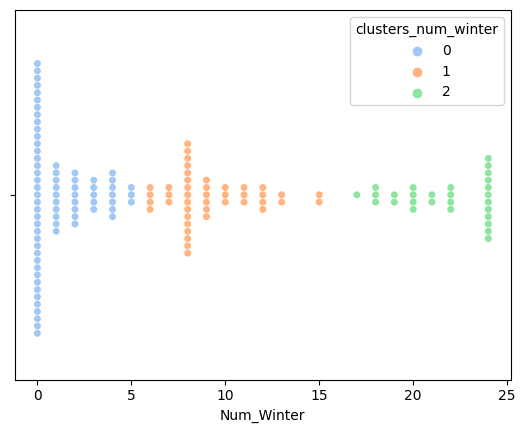

In [28]:
sns.swarmplot(df, x=num_winter[0], hue="clusters_num_winter", palette="pastel")
plt.show()

Ahora es turno de la cantidad de medallas ganadas por metal. Comenzamos por el Método del Codo,

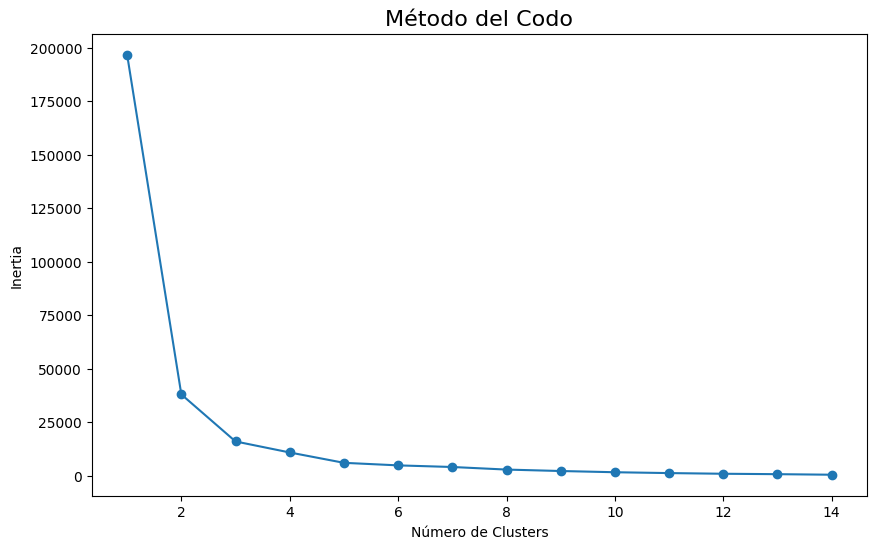

In [29]:
metodo_del_codo(data=df, columns=medals_winter)

En este caso parece que el número de clústers sera 2. Creamos los clústers, 

In [30]:
kmeans_medals_winter = KMeans(n_clusters=2, n_init="auto").fit(df[medals_winter])
df["clusters_medals_winter"] = kmeans_medals_winter.labels_

ordenamos,

In [31]:
euclidean_distance = df.groupby(by="clusters_medals_winter")[medals_winter].apply(lambda x: np.linalg.norm(x.mean())).sort_values()
df["clusters_medals_winter"] = df["clusters_medals_winter"].map(
	{old : int(new) for new,old in enumerate(euclidean_distance.index)}
)

y visualizamos

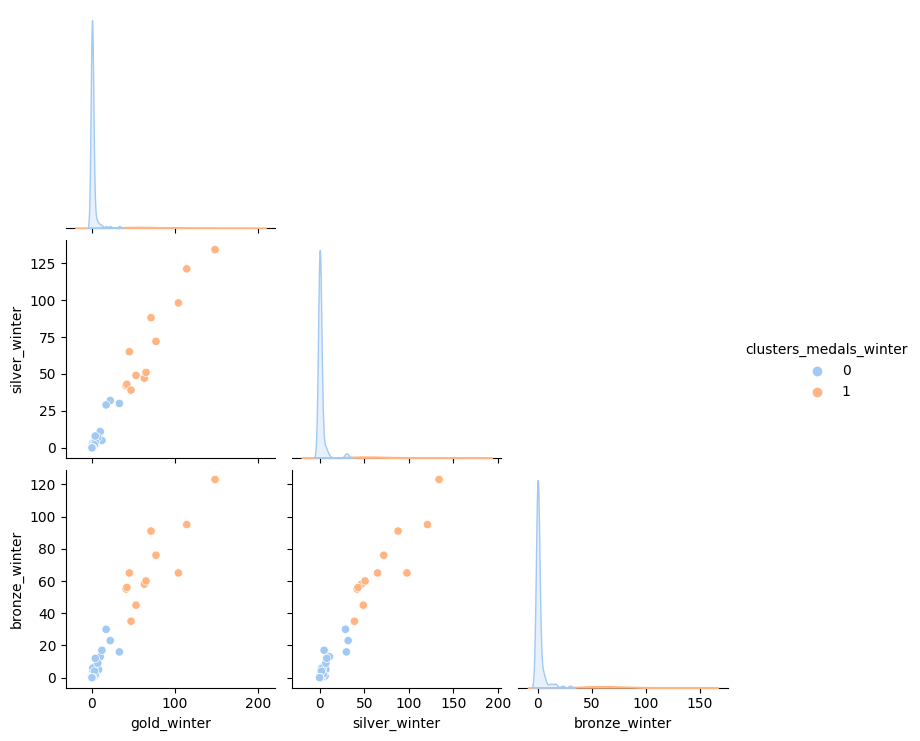

In [32]:
graficar_clusters(data=df, columnas=medals_winter, clusters_columna="clusters_medals_winter")

In [33]:
del (euclidean_distance, kmeans_medals_summer,
	kmeans_medals_winter, kmeans_num_summer,
	kmeans_num_winter, usa, mean_values)

### Categorías <a name="clustering-categorias"></a>

Ahora contamos con 4 nuevas columnas categóricas en `df`, cada una de ellas con un propósito. Creemos una lista con los nombres de estas columnas,

In [34]:
categorias = [
	"clusters_num_summer", "clusters_medals_summer",
	"clusters_num_winter", "clusters_medals_winter"
]

Para simplificar el proceso del análisis, llamaremos a cada columna categórica como 0, 1, 2 y 3, respectivamente. Esto concuerda con el índice de la lista que ocupan. De esta manera será más sencillo realizar el proceso de análisis sin abrumar con la mención de tantos nombres distintos.

Por supuesto, cuando llegue el momento de interpretar se regresarán a los nombres correctos.

## Visualización: Categorías en mapamundi <a name="visualizacion"></a>

Geopandas es un módulo dedicado a trabajar con datos geoespaciales. Se extiende de Pandas, por lo que permite operar con nuestro dataframe. Antes de comenzar, importemos el dataframe con los datos geométricos para dibujar el mapamundi,

In [35]:
world = gpd.read_file("data/mapamundi")

Los datos del mapamundi importado se aloja en una serie de archivos en el directorio `data/mapamundi`. Estos datos corresponden a un dataset que Geopandas tiene incorporado en versiones tempranas llamado `naturalearth_lowres`. Sin embargo, este dataset se ha removido en versiones posteriores.

Si bien este proyecto usa una versión de Geopandas que aún tiene el dataset naturalearth_lowres` disponible, se ha decidido que es mejor descargarlo e incluirlo en el repositorio. Esto tiene como finalidad evitar depender demasiado de las versiones de los módulos. Según la documentación de Geopandas, el dataset original puede obtenerse en la siguiente liga:

> https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

Regresando al proyecto, el objetivo de la visualización es colorear cada país de un determinado color dependiendo la clase a la que pertenece. En `word` tenemos alojados los datos de cada país así como la construcción geométrica, y cada registro se puede identificar dado el código ISO 3016-1 Alpha 3. 

Ahora crearemos una función para crear las gráficas:

In [36]:
def crear_mapamundi(data, categoria, world, title="", group_labels=None,
						legend=False, palette="Blues", figsize=(11, 9)):

	world_cat = world.merge(
		data, how="left", left_on="iso_a3", right_on="ISO_code"
	)
	fig, ax = plt.subplots(figsize=figsize)

	world_cat.boundary.plot(ax=ax, linewidth=1)
	world_cat.plot(column=categoria, ax=ax, legend=legend,
				legend_kwds={'labels': group_labels + ["Missing values"]},
				categorical=True, cmap=palette,
				missing_kwds={
					"color": "lightgrey",
					"edgecolor": "red",
					"hatch": "///"
    			}
				)
	ax.set_title(title)
	ax.set_xticks([])
	ax.set_yticks([])
	plt.show()

### Categoría 0: Número total de participantes en los JJ.OO. de Verano <a name="visualizacion-0"></a>

Recordemos que los grupos para esta categoría, que corresponden a la columna `clusters_num_summer`, son 0, 1 y 2. Estos está ordenados de menor a mayor y se muestra en la siguiente tabla, donde se muestra el mínimo y el máximo de participaciones dentro del grupo para mayor entendimiento,

In [37]:
df.groupby(by=categorias[0]).apply(
	lambda group: pd.Series(
		[group[num_summer[0]].apply(e) for e in ["min", "max"]]
	)
).rename(
	index={i : f"Grupo {i}" for i in range(3)},
	columns={0 : "min", 1 : "max"}
)

,min,max
clusters_num_summer,,
Grupo 0,3,12
Grupo 1,13,21
Grupo 2,22,30


Y podemos visualizarlas en el siguiente mapa,

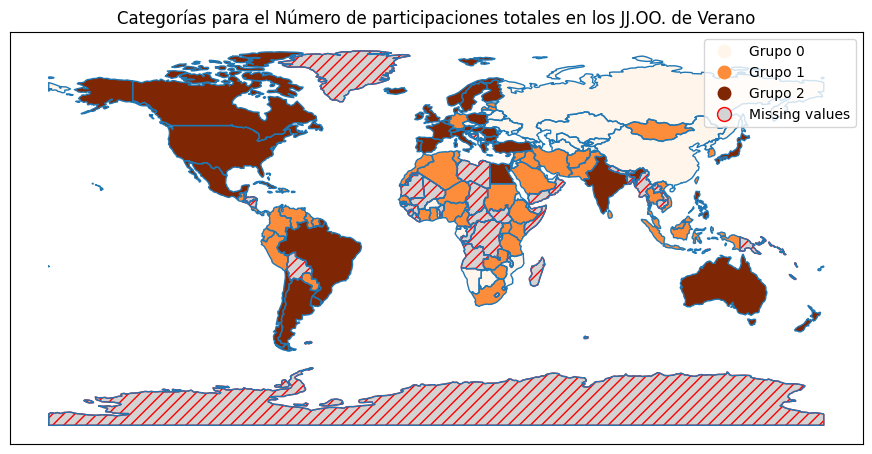

In [38]:
crear_mapamundi(df, categorias[0], world,
				title="Categorías para el Número de participaciones " +
					  "totales en los JJ.OO. de Verano",
				group_labels=[f"Grupo {i}" for i in range(3)],
				legend=True,
				palette="Oranges",
				)

### Categoría 1: Cantidad de medallas ganadas en los JJ.OO. de Verano <a name="visualizacion-1"></a>
Está categoría se refiere al número de medallas de oro, plata y bronce que han ganado cada país, y está contenida en la columna `clusters_medals_summer`. El ordenamiento en este caso es bastante más complejo. Se basa en *la distancia entre los centroides de cada grupo y el punto origen del espacio de configuraciones formado por la cantidad de medallas de oro, plata y bronce ganadas*.

Para evitar complicaciones, nos basaremos en términos de rendimiento, donde el criterio que se usó es el presentado en el párrafo anterior. Vamos a resumirlo en la siguiente tabla,

| Grupo | Rendimiento | 
|-------|-------------|
|   0   |    Bajo     |
|   1   |  Moderado   | 
|   2   |    Alto     | 

Comprendido lo anterior, avancemos con la visualización del mapamundi,

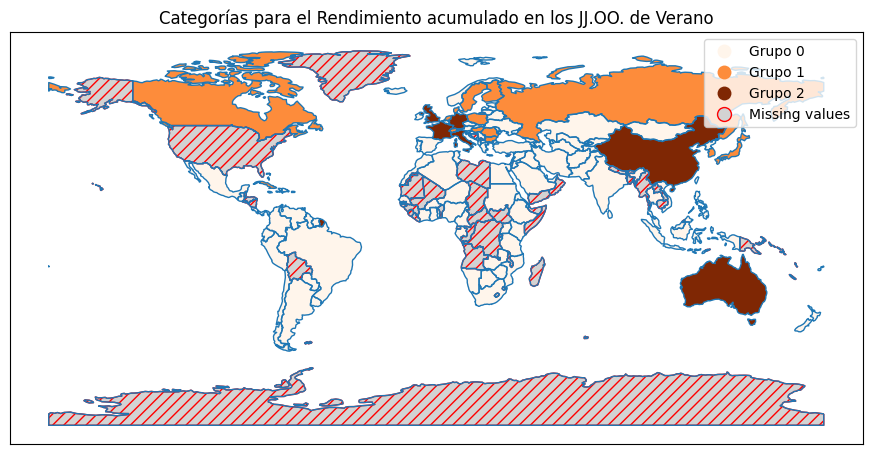

In [39]:
crear_mapamundi(df, categorias[1], world,
				title="Categorías para el Rendimiento acumulado " +
					  "en los JJ.OO. de Verano",
				group_labels=[f"Grupo {i}" for i in range(3)],
				legend=True,
				palette="Oranges",
				)

Cabe destacar que para esta categoría *USA no fue incluida dado que sus resultados mostraban resultados extremos*. En todo caso su rendimiento podría calificarse como *Sobresaliente*.

### Categoría 2: Número total de participantes en los JJ.OO. de Invierno <a name="visualizacion-2"></a>

Para esta categoría también tenemos tres grupos, numerados también como 0, 1 y 2. La columna correspondiente se llama `clusters_num_winter`. El ordenamiento también sigue la lógica anterior, clasificando los datos de mayor a menor. La siguiente tabla muestra los máximos y mínimos de cada grupo,

In [40]:
df.groupby(by=categorias[2]).apply(
	lambda group: pd.Series(
		[group[num_winter[0]].apply(e) for e in ["min", "max"]]
	)
).rename(
	index={i : f"Grupo {i}" for i in range(3)},
	columns={0 : "min", 1 : "max"}
)

,min,max
clusters_num_winter,,
Grupo 0,0,5
Grupo 1,6,15
Grupo 2,17,24


Entendido lo anterior, vamos con el mapamundi,

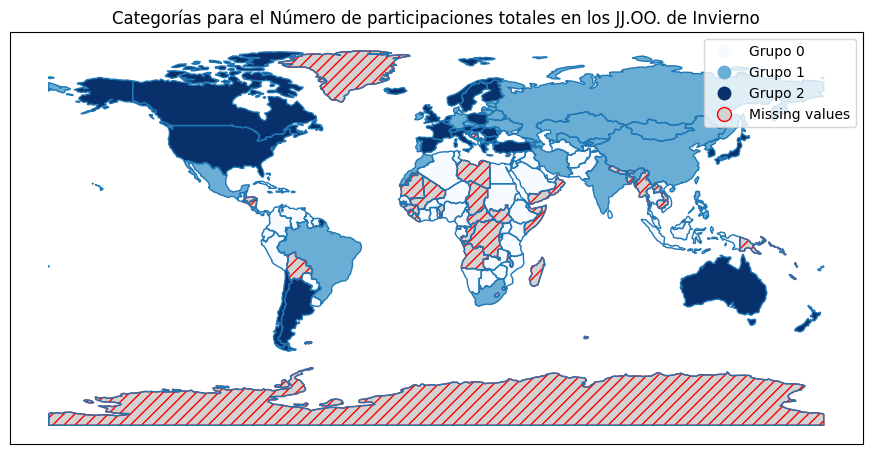

In [41]:
crear_mapamundi(df, categorias[2], world,
				title="Categorías para el Número de participaciones " +
					  "totales en los JJ.OO. de Invierno",
				group_labels=[f"Grupo {i}" for i in range(3)],
				legend=True,
				palette="Blues",
				)

### Categoría 3: Cantidad de medallas ganadas en los JJ.OO. de Invierno <a name="visualizacion-3"></a>

Para esta categoría, a diferencia de las anteriores, los grupos generados son 2; 0 y 1. La columna que contiene esta clasificación es `clusters_medals_winter`. Esta columna, al igual que a la semejante para la edición de Verano de los JJ.OO., se le ha denominado como el desempeño.

El ordenamiento sigue el mismo criterio: la *distancia del centroide de cada grupo con el origen del espacio de configuraciones*. Aunque siempre es mejor mantenerlo simple. Los grupos hay que entenderlos dada la siguiente tabla,

| Grupo | Rendimiento | 
|-------|-------------|
|   0   |    Bajo     | 
|   1   |    Alto     |

Y sin nada más que decir, miremos el mapamundi con la última categoría,

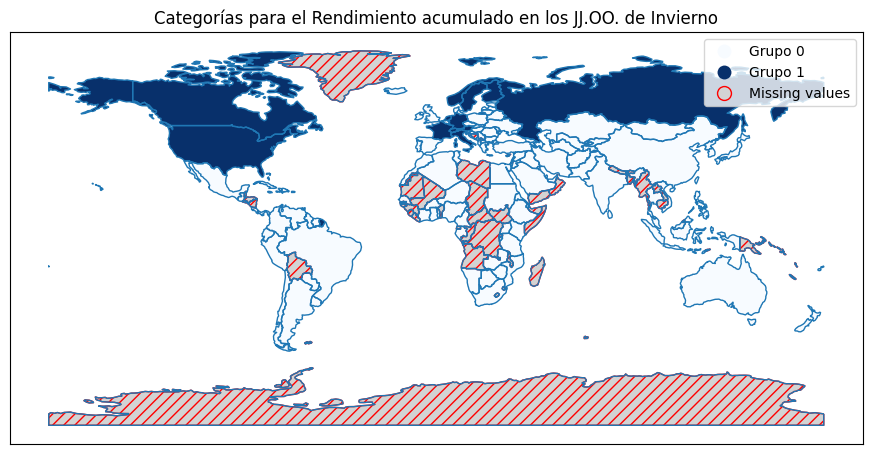

In [42]:
crear_mapamundi(df, categorias[3], world,
				title="Categorías para el Rendimiento acumulado " +
					  "en los JJ.OO. de Invierno",
				group_labels=[f"Grupo {i}" for i in range(2)],
				legend=True,
				palette="Blues",
				)

In [43]:
del world

## Clasificación con factores externos <a name="clasificacion"></a>

Esta sección se destinará a explorar algunos modelos de *Machine Learning* de clasificación. El objetivo es buscar patrones entre las clasificaciones o categorías que se obtuvieron anteriormente con Clustering usando los datos de medallas, con factores externos propios de cada país. Estos factories externos los hemos estado llamando como indicadores, y fueron obtenidos da la API del *Banco Mundial*,

In [44]:
indicadores

['latitude',
 'Access_to_electricity_media',
 'AFFVA_media',
 'Cause_of_death_by_media',
 'Control_of_Corruption_media',
 'Expenditure_on_education_media',
 'GDP_per_capita_media',
 'Health_expenditure_per_capita_media',
 'Prevalence_of_undernourishment_media',
 'Primary_completion_rate_media',
 'population_media',
 'Research_dev_expenditure_media',
 'surface_area_media',
 'Vulnerable_employment_media']

### Elección de indicadores <a name="eleccion-indicadores"></a>

Al inicio de este notebook ya se había realizado un primer filtro para los indicadores de cada país. Recordando, anteriormente se había realzado un análisis de correlación entre los parámetros olímpicos y estos indicadores y se habían seleccionado algunos para incluir en este análisis. Se seleccionaron aquellos indicadores cuya correlación fuera mayor o igual a $0.2$.

En esta ocasión se realizará un segundo filtro, usando también el análisis de correlación. Se han encontrado los mejores indicadores para cada categoría usando la matriz de correlación y observando las gráficas de dispersión. El objetivo es observar alguna clara separación entre las clases. Observemos la matriz de correlación correspondiente,

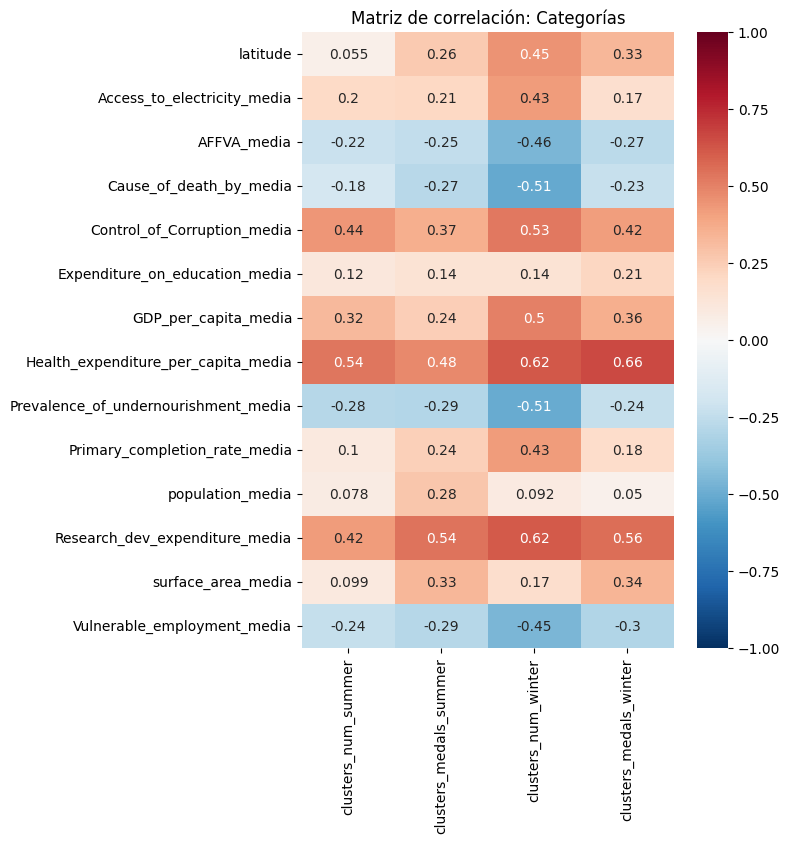

In [45]:
def grafico_de_correlación(corr, figsize=(6,8)):
	fig, ax = plt.subplots(figsize=figsize)

	sns.heatmap(data=corr,
			 cmap='RdBu_r', center=0,
			 vmin=-1, vmax=1, annot=True, ax=ax)
	ax.set_title("Matriz de correlación: Categorías")
	plt.show()

corr = df[indicadores + categorias].corr().loc[indicadores, categorias].copy()
grafico_de_correlación(corr)

La matriz a sido almacenada en el dataframe `corr`, el cual será usado para filtrar los mejores indicadores para cada categoría. Ya que se requiere observar la dispersión, hagamos una función para crear la gráfica correspondiente,

In [46]:
def graficas_dispersion(data, indicadores, categoria):
	sns.pairplot(
		data=data[indicadores + [categoria]],
		hue=categoria, palette="Set1", corner=True
	)

#### Categoria 0

Para la categoría 0, se ha decidido usar únicamente los indicadores con una correlación igual o mayor a $0.3$,

In [47]:
indicadores_0 = corr.loc[corr[categorias[0]].abs() >= 0.3, categorias[0]].index.to_list()
indicadores_0

['Control_of_Corruption_media',
 'GDP_per_capita_media',
 'Health_expenditure_per_capita_media',
 'Research_dev_expenditure_media']

Esto porque son los indicadores que presentan una mayor agrupación entre sus grupos en la gráfica de dispersión, 

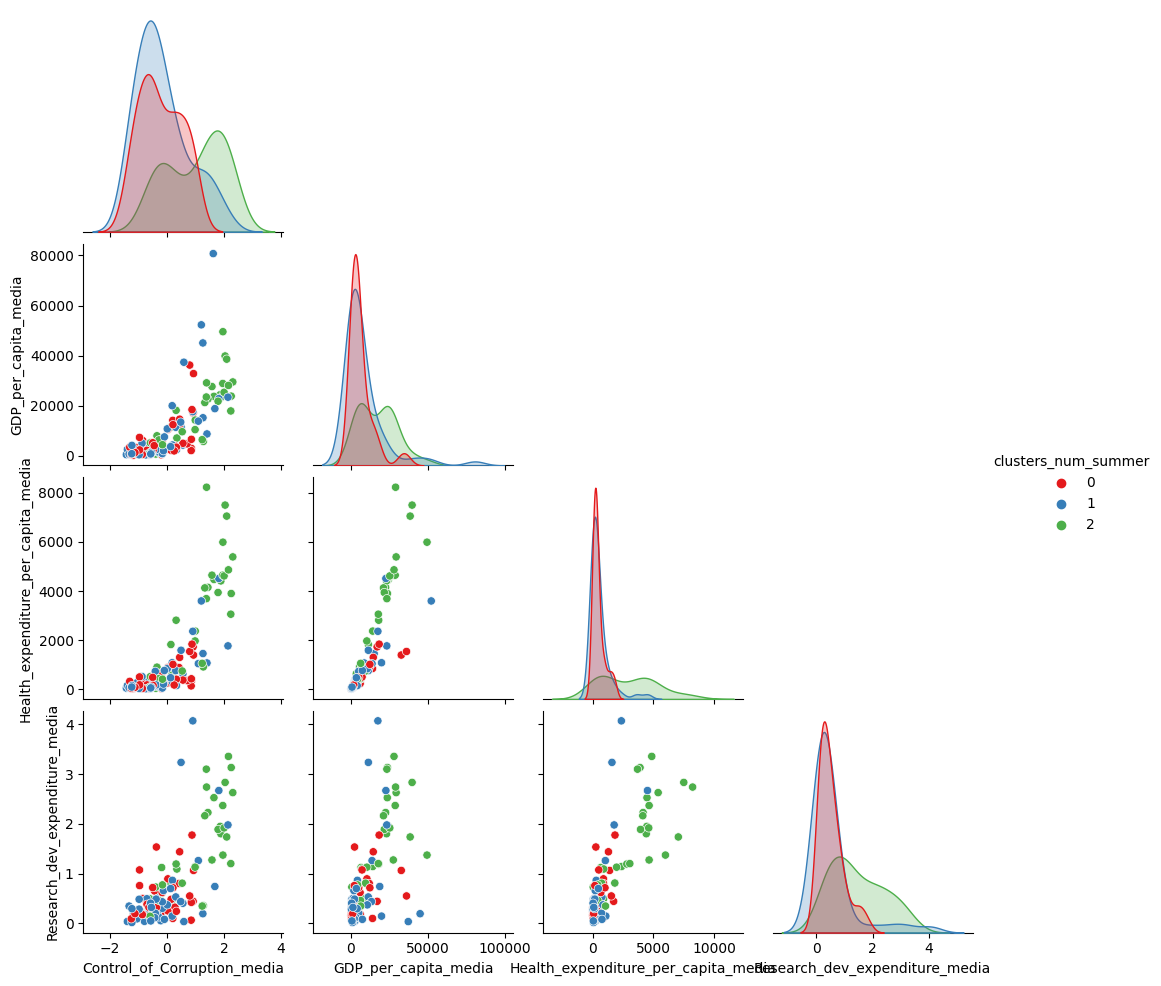

In [48]:
graficas_dispersion(data=df, indicadores=indicadores_0, categoria=categorias[0])

Sin embargo, cabe destacar, que la separación observada no es óptima para los indicadores que tenemos disponibles. Aunque se puede observar que el grupo 2 está bastante agrupado, el grupo 0 y el grupo 1 se mezclan en el mismo cúmulo. 

#### Categoría 1

Para la Categoría 1 se han elegido los indicadores que presenten una correlación mayor que $0.33$

In [49]:
indicadores_1 = corr.loc[corr[categorias[1]].abs() >= 0.33, categorias[1]].index.to_list()
indicadores_1

['Control_of_Corruption_media',
 'Health_expenditure_per_capita_media',
 'Research_dev_expenditure_media']

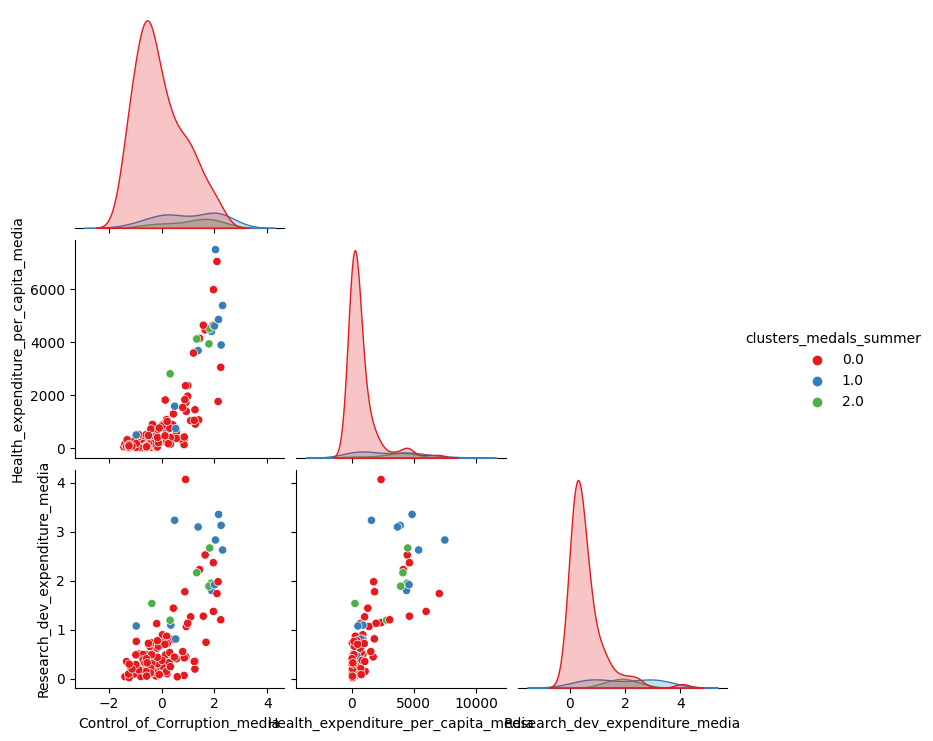

In [50]:
graficas_dispersion(data=df, indicadores=indicadores_1, categoria=categorias[1])

Como se puede observar, la clasificación también será complicada en este caso, dado que los grupos tienden a combinarse mucho entre sí. También cabe destacar que existe un gran desbalance de datos, lo cual será discutido más adelante.

#### Categoría 2

Esta categoría es bastante interesante, ya que es aquella que muestra mayor correlación con la mayoría de los indicadores. Obviando a los que que tienen correlación menor a $0.2$, todos los demás tiene una correlación arriba de $0.42$. Este será la categoría donde se usarán más indicadores en el modelo de clasificación,

In [51]:
indicadores_2 = corr.loc[corr[categorias[2]].abs() >= 0.42, categorias[2]].index.to_list()
indicadores_2

['latitude',
 'Access_to_electricity_media',
 'AFFVA_media',
 'Cause_of_death_by_media',
 'Control_of_Corruption_media',
 'GDP_per_capita_media',
 'Health_expenditure_per_capita_media',
 'Prevalence_of_undernourishment_media',
 'Primary_completion_rate_media',
 'Research_dev_expenditure_media',
 'Vulnerable_employment_media']

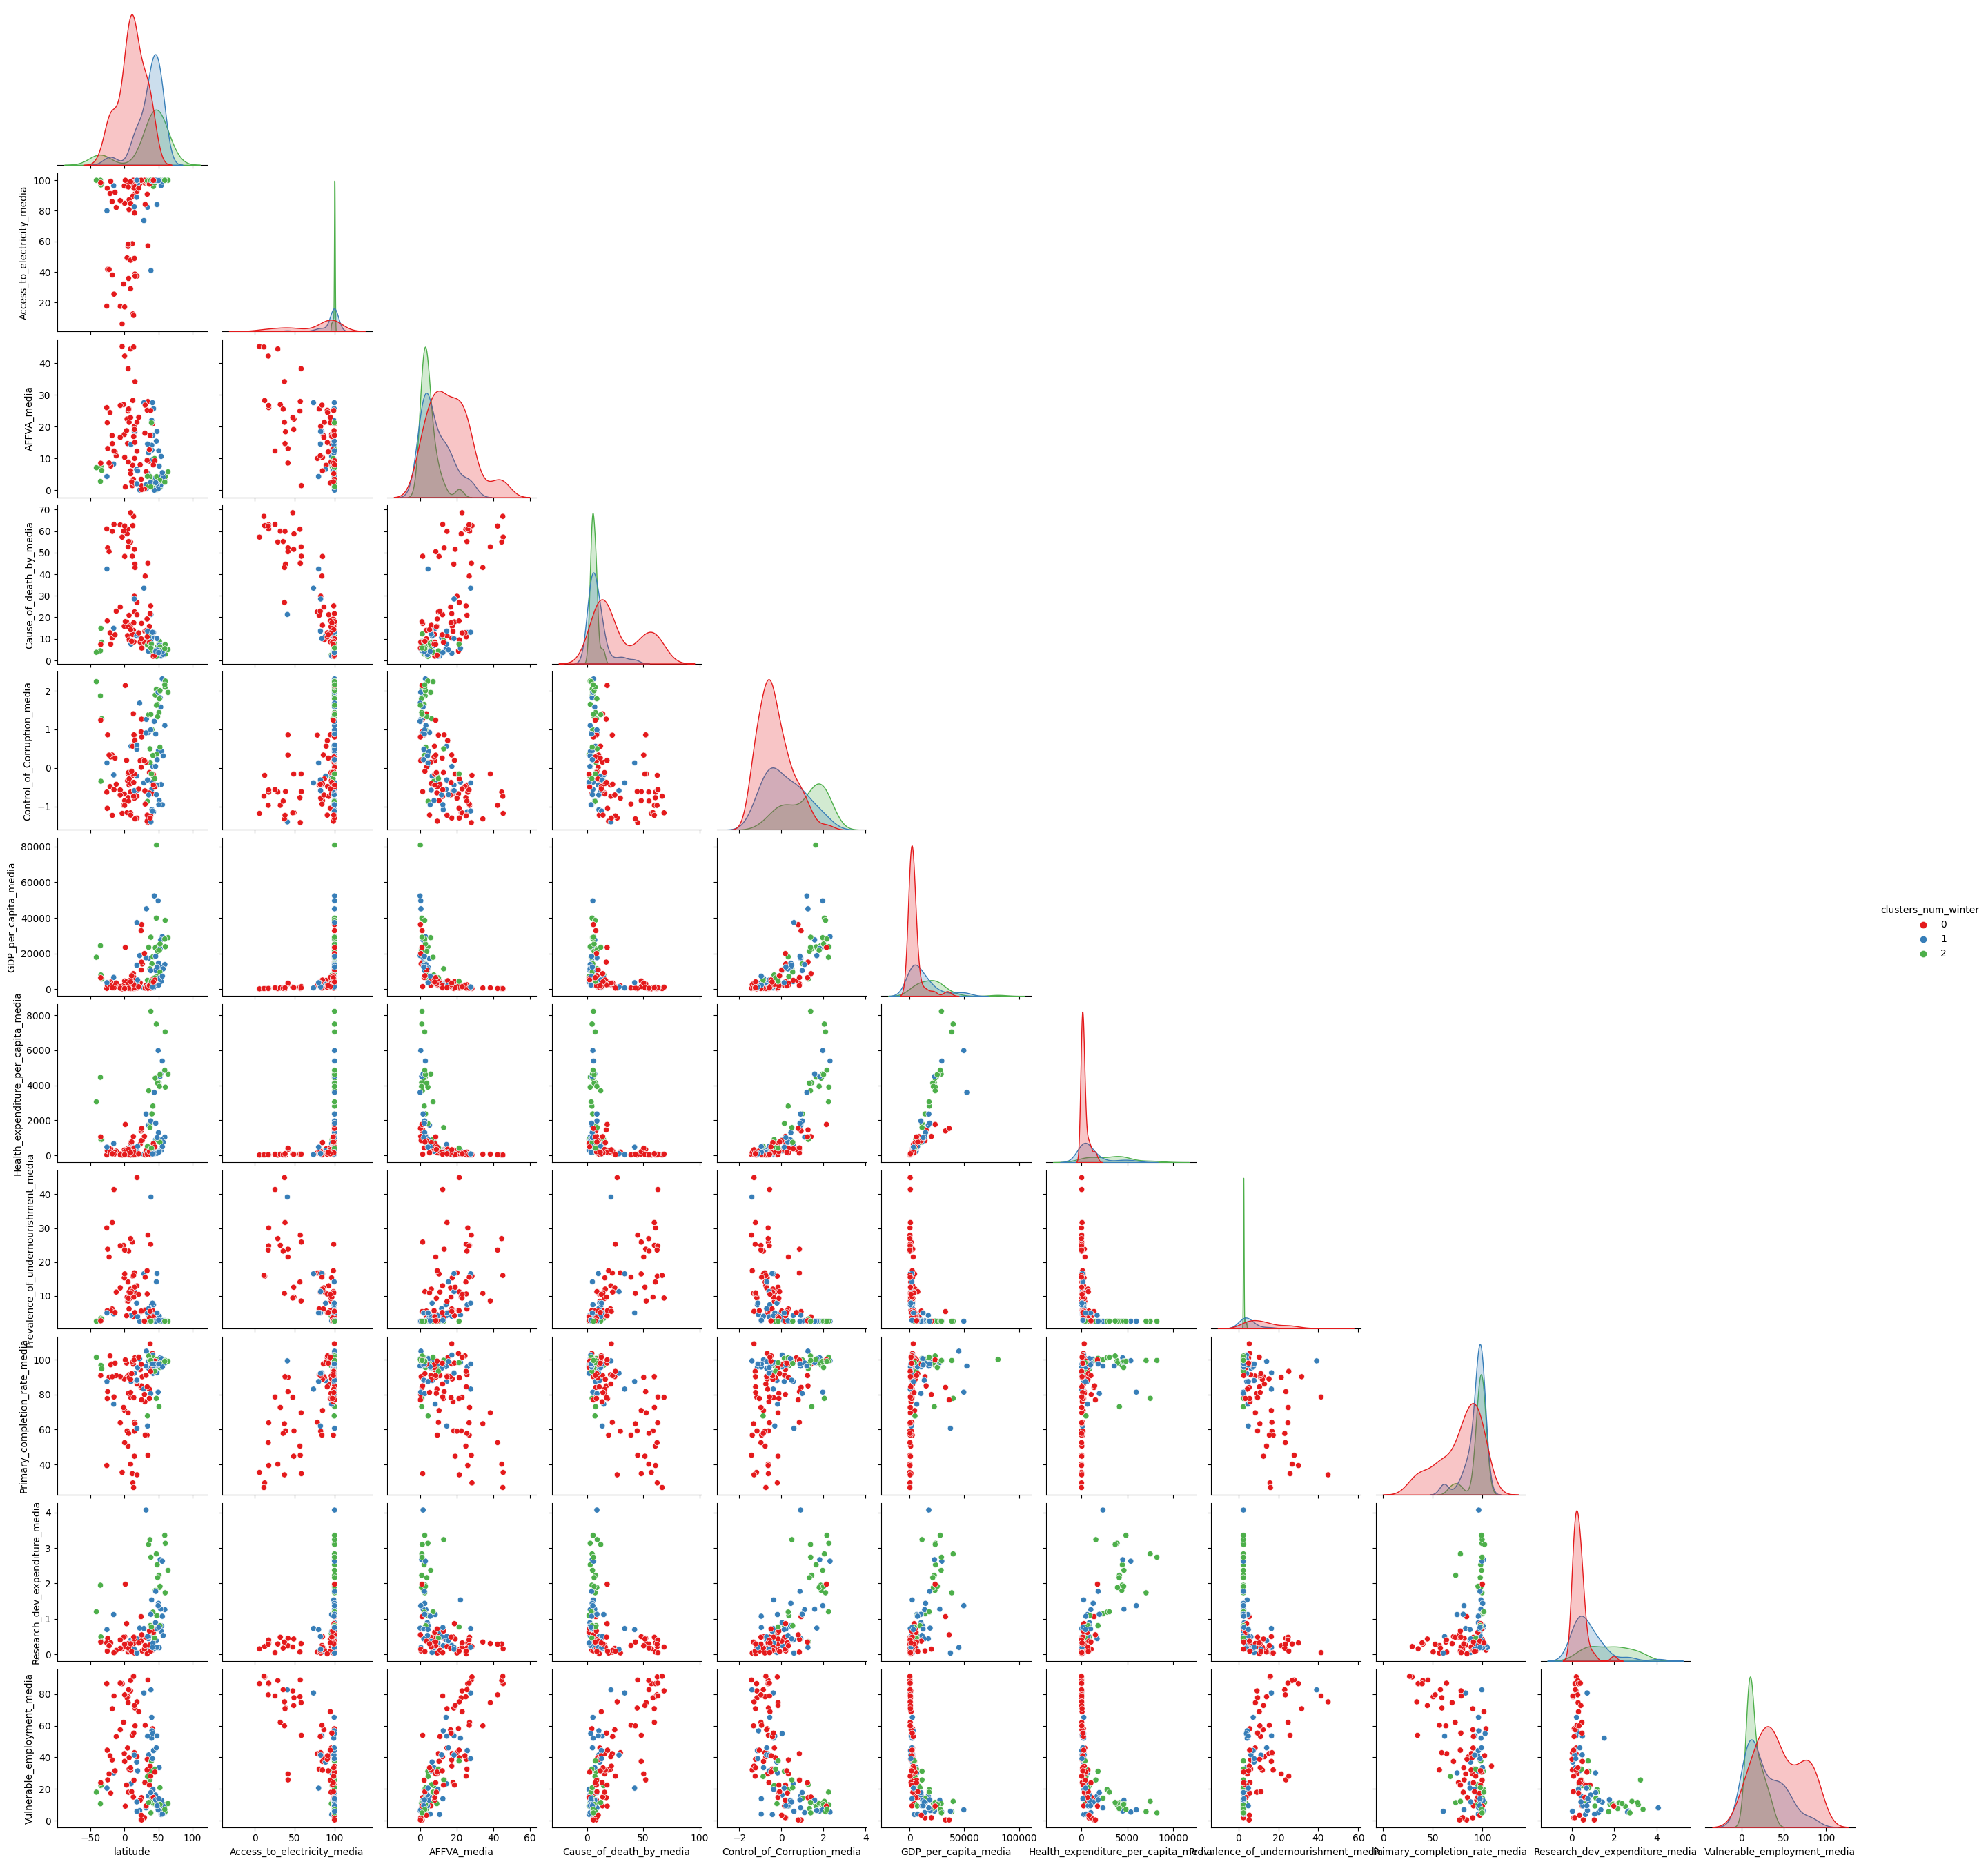

In [52]:
graficas_dispersion(data=df, indicadores=indicadores_2, categoria=categorias[2])

#### Categoría 3
Y para la última categoría, la número 3, se ha decidido usar los indicadores con una correlación mayor a 0.3,

In [53]:
indicadores_3 = corr.loc[corr[categorias[3]].abs() >= 0.3, categorias[3]].index.to_list()
indicadores_3

['latitude',
 'Control_of_Corruption_media',
 'GDP_per_capita_media',
 'Health_expenditure_per_capita_media',
 'Research_dev_expenditure_media',
 'surface_area_media',
 'Vulnerable_employment_media']

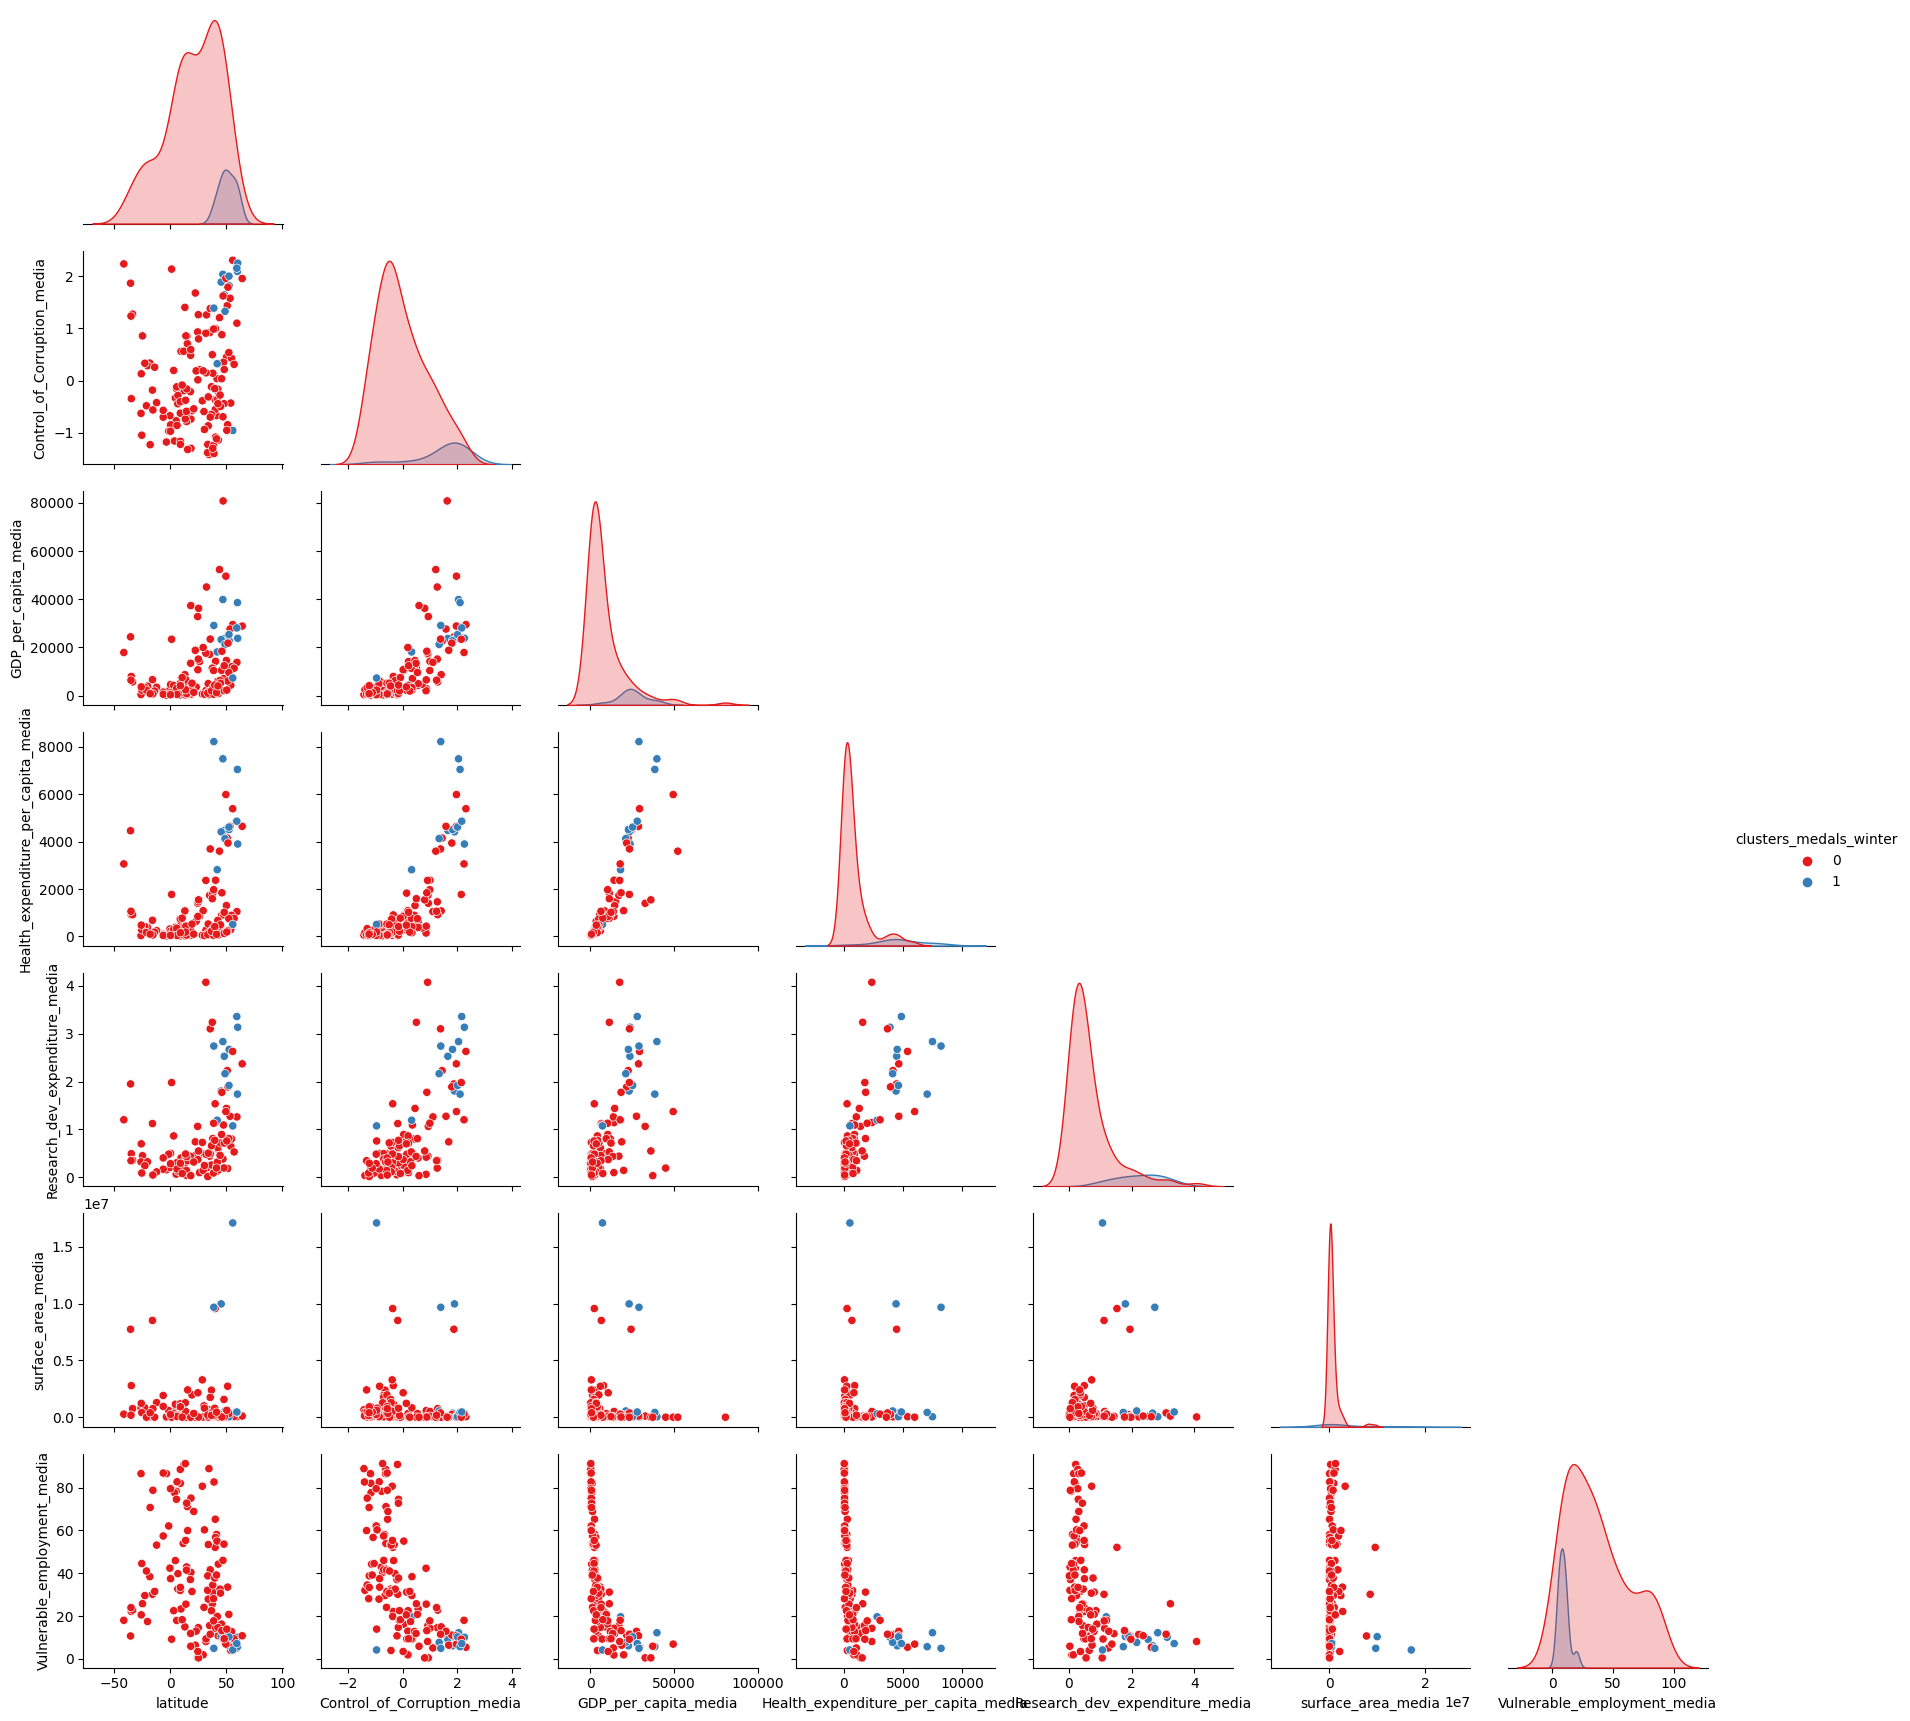

In [54]:
graficas_dispersion(data=df, indicadores=indicadores_3, categoria=categorias[3])

Esta es la única categoría binaria entre las 4 que analizaremos, y también es la que parece tener un desbalance extremo.

### Un poco más de tratamiento <a name="mas-tratamiento"></a>

El volumen de datos con los que disponemos es poco, con poco más de 140 registros. Sin embargo, tenemos bastantes valores nulos entre los indicadores que nos podría dar problemas,

In [55]:
df[indicadores].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   latitude                              141 non-null    float64
 1   Access_to_electricity_media           141 non-null    float64
 2   AFFVA_media                           139 non-null    float64
 3   Cause_of_death_by_media               133 non-null    float64
 4   Control_of_Corruption_media           141 non-null    float64
 5   Expenditure_on_education_media        137 non-null    float64
 6   GDP_per_capita_media                  140 non-null    float64
 7   Health_expenditure_per_capita_media   134 non-null    float64
 8   Prevalence_of_undernourishment_media  124 non-null    float64
 9   Primary_completion_rate_media         139 non-null    float64
 10  population_media                      141 non-null    float64
 11  Research_dev_expend

Sin embargo, recordemos que no todos los indicadores anteriores serán usados, y no todas las categorías usarán los mismos indicadores. Por eso se crearán 4 diferentes dataframes, cada uno dedicado a cada categoría. Así la limpieza se realizará de forma separada,

In [56]:
df_cat = []

for cat,ind in zip(categorias, [indicadores_0, indicadores_1, indicadores_2, indicadores_3]):
	df_cat.append(
		df[ind + [cat]].dropna(how="any")
	)

`df_cat` es una lista que contiene los dataframes que será usados para cada categoría. Ahora podemos revisar la cantidad de registros que tiene cada uno,

In [57]:
{f'Categoria {i}' : df_cat[i].shape[0] for i in range(4)}

{'Categoria 0': 114,
 'Categoria 1': 113,
 'Categoria 2': 107,
 'Categoria 3': 114}

Por lo que hemos logrado conservar la mayor parte de los datos para cada categoría.

In [58]:
del corr, cat, ind

### Regresión logística <a name="regresion-logistica"></a>

Comencemos con el primer modelo a probar. La regresión logística, a pesar de su nombre, es un algoritmo de Clasificación. Normalmente es usada para clasificación binaria, pero es posible expandirla para varias clases.

Antes de adentrarnos a la regresión logística, necesitamos revisar la distribución de las clases en los datos

In [59]:
pd.concat(
	[(df[c].value_counts(normalize=True)).to_frame(name=c) for c in categorias],
	axis=1
).sort_index() * 100

,clusters_num_summer,clusters_medals_summer,clusters_num_winter,clusters_medals_winter
0.0,31.690141,85.815603,50.00000,91.549296
1.0,42.957746,9.929078,30.28169,8.450704
2.0,25.352113,4.255319,19.71831,NaN


Por lo visto existen algunas categorías con desbalance. Resalta `clusters_medals_winter` con un desbalance bastante extremo, lo que se tendrá que tener en cuenta en el futuro.

#### Categoría 0

Comencemos con la creación del modelo para `clusters_num_summer`, el número de participaciones en los JJ.OO. de Verano. Procedemos con una normalización de los datos para facilitar el desempeño de los datos de entrada $X$,

In [60]:
X = df_cat[0][indicadores_0]
y = df_cat[0][categorias[0]]

X_scaled = StandardScaler().fit_transform(X)


Dividimos los datos en datos para entrenamiento (*train*) y para prueba (*test*)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
	X_scaled, y, test_size=0.25, stratify=y, random_state=42
)

del X, y, X_scaled

Y aplicamos el modelo,

In [62]:
lr = LogisticRegression(solver="lbfgs", random_state=42).fit(X_train, y_train)
lr

LogisticRegression(random_state=42)

Ahora solo es cuestión de probar el modelo con los datos de prueba, y evaluar

In [63]:
predict = lr.predict(X_test)
exactitud = accuracy_score(y_test, predict)
f1 = f1_score(y_test, predict, average="weighted")
cmatrix = confusion_matrix(y_test, predict)

print(f"La exactitud es de {round(exactitud * 100, 2)}%")
print(f"El valor F1 es de {round(f1, 4)}")

La exactitud es de 62.07%
El valor F1 es de 0.6068


Lo anterior indica que poco más de $58\%$ de las pruebas fueron acertadas por el modelo, y el valor de F1 es similar, lo que indica que el rendimiento del modelo es moderado. Observemos la matriz de confusión,

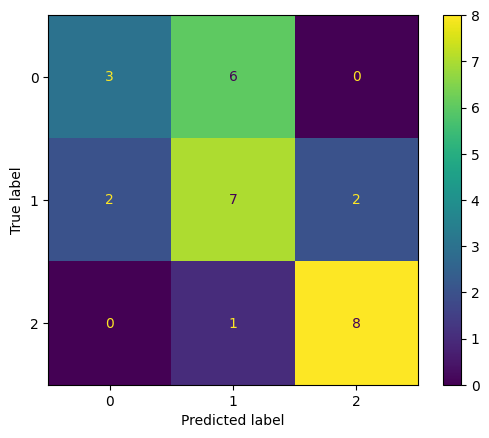

In [64]:
ConfusionMatrixDisplay(cmatrix).plot()
plt.show()

En la Matriz de Confusión podemos observar que el modelo es bastante bueno para identificar elementos del Grupo 2, pero no tanto para el grupo 0. Por su parte, también muestra que el modelo confunde mucho los elementos del grupo 0 con el grupo 1. Esto es bastante esperado, ya que, como lo reveló la gráfica de dispersión de datos, el grupo 1 y el grupo 0 no tiene una separación clara.

Ahora apliquemos Cross Validation para encontrar los mejores hiperparámetros entre el algoritmo a utilizar. De paso crearemos una función para poder aplicar en las categorías siguientes, 

In [65]:
warnings.filterwarnings("ignore", category=FitFailedWarning)

def cross_validation_lr(X_, y_, params_extras={}):
	logreg = LogisticRegression(random_state=42, max_iter=300, n_jobs=-1)
	params = {
		"solver" : ["lbfgs", "newton-cg", "sag"],
		"C" : [0.1, 0.5, 1.0, 1.5, 2],
		"class_weight" : ["balanced", None]
	}
	params.update(params_extras)

	return RandomizedSearchCV(logreg, params, random_state=42, n_jobs=-1).fit(X_, y_)

model_cv = cross_validation_lr(X_train, y_train)

donde los mejores hiperparametros son,

In [66]:
model_cv.best_params_

{'solver': 'lbfgs', 'class_weight': None, 'C': 0.5}

Ahora evaluemos el nuevo modelo, tal y como lo hicimos antes,

In [67]:
def calificar_modelo(X_, y_, model, f1_average="weighted"):
	predict = model.predict(X_)
	exactitud = accuracy_score(y_, predict)
	f1 = f1_score(y_, predict, average=f1_average)
	cmatrix = confusion_matrix(y_, predict)

	print(f"La exactitud es de {round(exactitud * 100, 2)}%")
	print(f"El valor F1 es de {round(f1, 4)}")

	return exactitud, f1, cmatrix

exactitud, f1, cmatrix = calificar_modelo(X_test, y_test, model_cv)

La exactitud es de 58.62%
El valor F1 es de 0.556


Y la matriz de confusión es la siguiente,

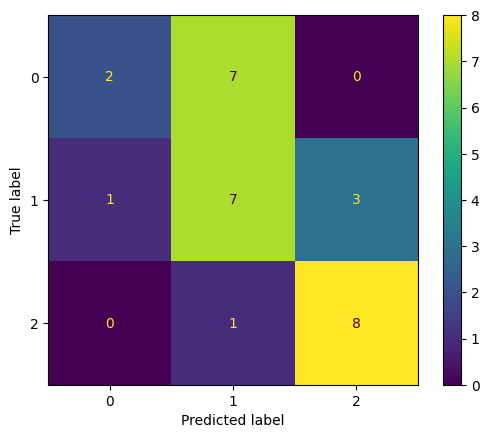

In [68]:
ConfusionMatrixDisplay(cmatrix).plot()
plt.show()

Y por lo que vemos el modelo obtenido con Cross Validation no tiene mucha diferencias al anterior. A continuación, en todas las demás categorías se utilizará Cross validation directamente para crear el modelo.

#### Categoría 1

Comencemos el modelo para la clase 1, `clusters_medals_summer`, que hemos entendido como el desempeño de los países en los JJ.OO. de Verano. Normalizamos los datos,

In [69]:
X = df_cat[1][indicadores_1]
y = df_cat[1][categorias[1]]
X_scaled= StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
	X_scaled, y, test_size=0.30, stratify=y, random_state=42
)

del X, y, X_scaled

En este caso, tomaremos un conjunto de test más grande ($30\%$) que en el anterior caso para intentar compensar el desequilibro entre las clases. Creamos el modelo,

In [70]:
model_cv = cross_validation_lr(X_train, y_train)
model_cv.best_params_

/home/leodan52/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/leodan52/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leodan52/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leodan52/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leodan52/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/leodan52/.local/lib/python3.8/site-packages/sklearn/l

{'solver': 'lbfgs', 'class_weight': None, 'C': 2}

En este caso podemos observar que los mejores hiperparámetros son diferentes que en lo anterior. Califiquemos el modelo, 

In [71]:
exactitud, f1, cmatrix = calificar_modelo(X_test, y_test, model_cv)

La exactitud es de 85.29%
El valor F1 es de 0.821


El desempeño del modelo para la categoría 1 es bastante mejor que la anterior. Con una exactitud mayor mayor a $75\%$ y un valor F1 de poco mas de $0.73$, el modelo está mostrando un rendimiento promedio aceptable. Sin embargo, como estamos trabajando con Regresión Logística, lo mejor es analizar la Matriz de Confusión,

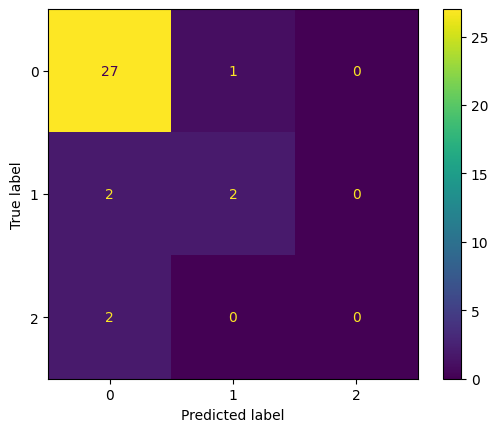

In [72]:
ConfusionMatrixDisplay(cmatrix).plot()
plt.show()

Lamentablemente el desbalance de datos es demasiado exagerado. La presencia de datos del Grupo 0 es bastante alta, por lo que el modelo está completamente sesgado a ello,

In [73]:
df_cat[1][categorias[1]].value_counts()

0.0    93
1.0    14
2.0     6
Name: clusters_medals_summer, dtype: int64

Teniendo solo 9 datos en el grupo 2 para la categoría 1 es insuficiente para el entrenamiento del modelo. Es posible intentar equilibrar el dataframe tomando una muestra suficientemente pequeña del grupo 0, pero eso disminuiría el volumen de datos disponibles.

#### Categoría 2

Ahora es turno de la categoría 2, `clusters_num_winter`, que es el número de participaciones en los JJ.OO. de Invierno. Sin más dilación, comencemos:

Normalización y división de los datos,

In [74]:
X = df_cat[2][indicadores_2]
y = df_cat[2][categorias[2]]
X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
	X_scaled, y, test_size=0.25, stratify=y, random_state=42
)

del X, y, X_scaled

Creación del modelo,

In [75]:
model_cv = cross_validation_lr(X_train, y_train)
model_cv.best_params_

{'solver': 'lbfgs', 'class_weight': 'balanced', 'C': 0.1}

y la respectiva evaluación,

In [76]:
exactitud, f1, cmatrix = calificar_modelo(X_test, y_test, model_cv)

La exactitud es de 48.15%
El valor F1 es de 0.4848


Los valores de exactitud y F1 son bastante bajos. Técnicamente estos valores podrían considerarse moderados, pero también indicaría que el modelo no es mejor que el azar para clasificar. Demos un vistazo a la Matriz de Confusión,

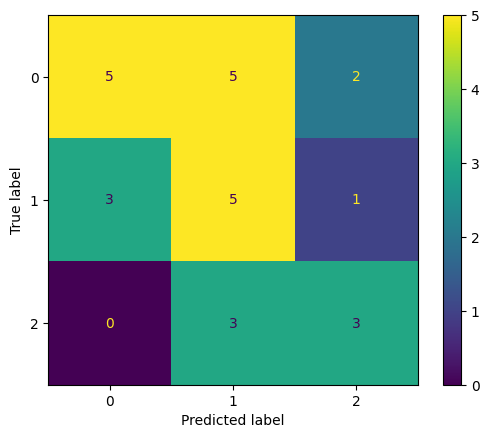

In [77]:
ConfusionMatrixDisplay(cmatrix).plot()
plt.show()

Como se puede observar, el modelo tiene problemas identificando elementos del grupo 2, así como confunde mucho los elementos del grupo 0 por los del grupo 1. Por supuesto, en el dataframe tenemos un poco de desequilibrio, donde el grupo 0 es el más numeroso y el grupo 2 tiene menos representación, donde se podría derivar el sesgo que presenta. 

Es también indicativo que en la gráfica de dispersión de los indicadores, los grupos no mostraban una separación notable.

In [78]:
categorias[3]

'clusters_medals_winter'

#### Categoría 3

Para finalizar este experimento con Regresión Logística, tenemos la categoría 3: 'clusters_medals_winter', o bien, el desempeño en los JJ.OO. de Invierno. Esta categoría es la única binaria entre las 4 analizadas, qué es donde está el fuerte de este modelo de *Machine Learning*. 

Comencemos como siempre, dando el tratamiento inicial de los datos,

In [79]:
X = df_cat[3][indicadores_3]
y = df_cat[3][categorias[3]]
X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
	X_scaled, y, test_size=0.25, stratify=y, random_state=42
)

del X, y, X_scaled

Luego continuaremos con el modelo. Dado que ahora tenemos una clasificación binaria, es posible usar una variedad más grande de algoritmos para realizar cross validation, 

In [80]:
params = {
	"solver" : ["lbfgs","liblinear", "newton-cholesky", "newton-cg", "sag"],
	"penalty" : ["l1", "l2"]
}

model_cv = cross_validation_lr(X_train, y_train, params_extras=params)
model_cv.best_params_

/home/leodan52/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.88235294        nan 0.91764706
        nan        nan        nan        nan]
  warnings.warn(


{'solver': 'sag', 'penalty': 'l2', 'class_weight': None, 'C': 0.5}

Y evaluamos el modelo,

In [81]:
exactitud, f1, cmatrix = calificar_modelo(X_test, y_test, model_cv, f1_average="binary")

La exactitud es de 89.66%
El valor F1 es de 0.4


La evaluación obtenida es bastante interesante en este caso. Por un lado, la exactitud muestra un porcentaje bastante algo que podría sugerir un buen modelo. Sin embargo, el valor F1 muestra lo contrario; un modelo bastante ineficiente.

Recordemos que la categoría 3 era la más desbalanceada de las 4. La exactitud alta podría deberse a que el modelo está clasificando la mayor parte de los datos correctamente en el grupo 0, lo cual seria correcto la mayor parte de las veces ya que este grupo representa la gran mayoría. Miremos entonces la Matriz de Confusión,

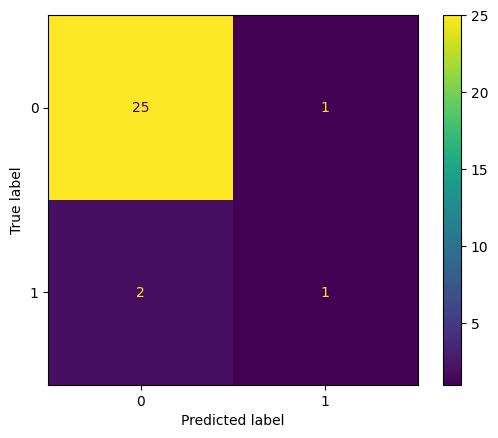

In [82]:
ConfusionMatrixDisplay(cmatrix).plot()
plt.show()

Como podemos observar, apenas tenemos 3 registros que son del grupo 1, y solo clasificó bien a 1. Y por otro lado tenemos 25 registros del grupo 0 agrupados correctamente, y solo 1 quedó fuera. El desbalance extremo impide que el modelo pueda aprender suficiente del grupo 1 para poder realizar clasificaciones correctas. 

De nueva cuenta, este modelo ha fallado.

In [83]:
del cmatrix, exactitud, f1, lr, model_cv, params, predict

### Árbol de decisión <a name="arbol-decision"></a>

El árbol de decisión es un modelo de *Machine Learning* que también se utiliza para clasificación. La idea central es bastante simple: crea un árbol donde cada hoja o nodo toma una decisión basado en alguna condición. La decisión tomada conduce a otro nodo, y a otro, hasta lograr clasificar a todos los elementos.

El problema del árbol de decisión es que es muy susceptible al *overfitting*, o sobreajuste en español. Este es un problema ya que lo que se busca de un modelo de clasificación es una gran generalización, es decir, que pueda ser usado con datos externos. Un modelo con *overfitting* suele ser eficiente con los datos de entrenamiento, pero ineficiente con externos.

A continuación se crearán los modelos usando Árboles de decisión y aplicando Cross Validation para encontrar el mejor modelo. La siguiente función hará ese trabajo,

In [84]:
def cross_validation_dtc(X_, y_, params_extras={}):
	logreg = DecisionTreeClassifier(random_state=42, class_weight="balanced")
	params = {
		#"criterion" : ["gini", "entropy", "log_loss"],
		"max_depth" : range(2, 20),
		"min_samples_leaf" : [1, 2, 3],
		"max_features" : ["sqrt", "log2", None],
		"min_samples_split" : range(2, 20)
	}
	params.update(params_extras)

	return RandomizedSearchCV(logreg, params, random_state=42, n_jobs=-1).fit(X_, y_)

Seguiremos usando búsqueda aleatoria para el Cross Validation en este caso. Por otro lado, para evaluar, seguiremos usando la función `calificar_modelo()` anteriormente definida para obtener la exactitud, el valor F1 y la matriz de confusión.

#### Categoría 0

Comencemos con la categoría 0. Comencemos dividiendo los datos para entrenamiento y prueba. La normalización no es necesaria en este caso,

In [85]:
X = df_cat[0][indicadores_0]
y = df_cat[0][categorias[0]]

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.25, stratify=y, random_state=42
)

del X, y

Y creamos el modelo,

In [86]:
model_cv = cross_validation_dtc(X_train, y_train)
model_cv.best_params_

{'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 4}

In [87]:
model_cv.best_estimator_.get_depth()

4

Dado Cross Validation, podemos ver que la profundidad máxima (`max_dept`) es 4, y la profundidad elegida también es 4. Esto indica que el árbol de decisión tiene 4 niveles, lo cual podemos visualizar,

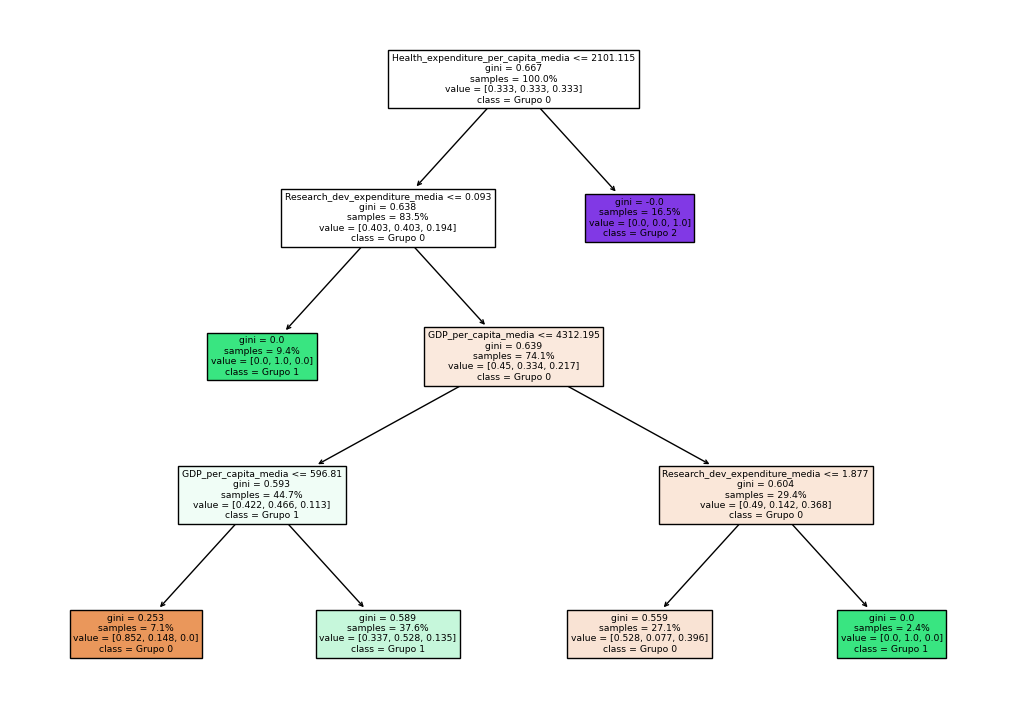

In [88]:
def visualizar_arbol(model_tree, class_names=None,
					feature_names=None, max_depth=None,
					figsize=(13,9)):

	fig, ax = plt.subplots(figsize=figsize)
	plot_tree(
		model_tree, feature_names=feature_names,
		filled=True, proportion=True,
		class_names=class_names, max_depth=max_depth
	)
	plt.show()

visualizar_arbol(
	model_cv.best_estimator_, class_names=[f"Grupo {i}" for i in range(3)],
	feature_names=X_train.columns.to_list()
)

Como podemos ver, el diagrama de árbol tiene 4 niveles. Cada nodo identifica la "decisión" que se realiza y lo que genera la bifurcación. El color de cada nodo indica la pureza de cada nodo, donde cada clase tiene un color asignado. Entre más intenso sea un color, el nodo tendrá una mayor dominancia de la clase correspondiente.

Por lo que podemos ver, los colores que se han asignado son, a grandes rasgos, naranja, verde y púrpura, cada uno representando al Grupo 0, 1 y 2, respectivamente.

Ahora, evaluemos el modelo como lo hicimos anteriormente,

In [89]:
exactitud, f1, cmatrix = calificar_modelo(X_test, y_test, model_cv)

La exactitud es de 44.83%
El valor F1 es de 0.4517


Al parecer el desempeño del modelo es bajo. Menos de la mitad de los datos de prueba han sido predichos correctamente, y el valor F1 es bastante moderado. Miremos la Matriz de confusión para entender mejor lo que está pasando,

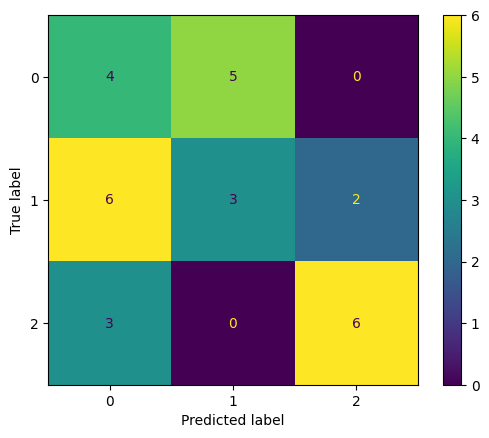

In [90]:
ConfusionMatrixDisplay(cmatrix).plot()
plt.show()

Al parecer el modelo es bastante bueno en clasificar el grupo 2, pero los otros grupos los confunde bastante entre sí. Como ya habíamos dicho antes, este comportamiento es esperado, ya que los grupos 0 y 1 no tienen una clara separación en el espacio formado por los indicadores escogidos para este modelo de clasificación.

#### Categoría 1

Es turno de la categoría 1. Vamos con el tratamiento correspondiente de los datos,

In [91]:
X = df_cat[1][indicadores_1]
y = df_cat[1][categorias[1]]

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.25, stratify=y, random_state=42
)

del X, y

E inmediatamente creamos el modelo,

In [92]:
model_cv = cross_validation_dtc(X_train, y_train)
model_cv.best_params_

{'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 11}

In [93]:
model_cv.best_estimator_.get_depth()

5

En este caso, el cross validation consideró una profundidad máxima de 12, pero la profundidad del árbol es 7. Es demasiado para poder visualizarlo completamente en este documento. Miremos, por ende, una fracción del diagrama de árbol

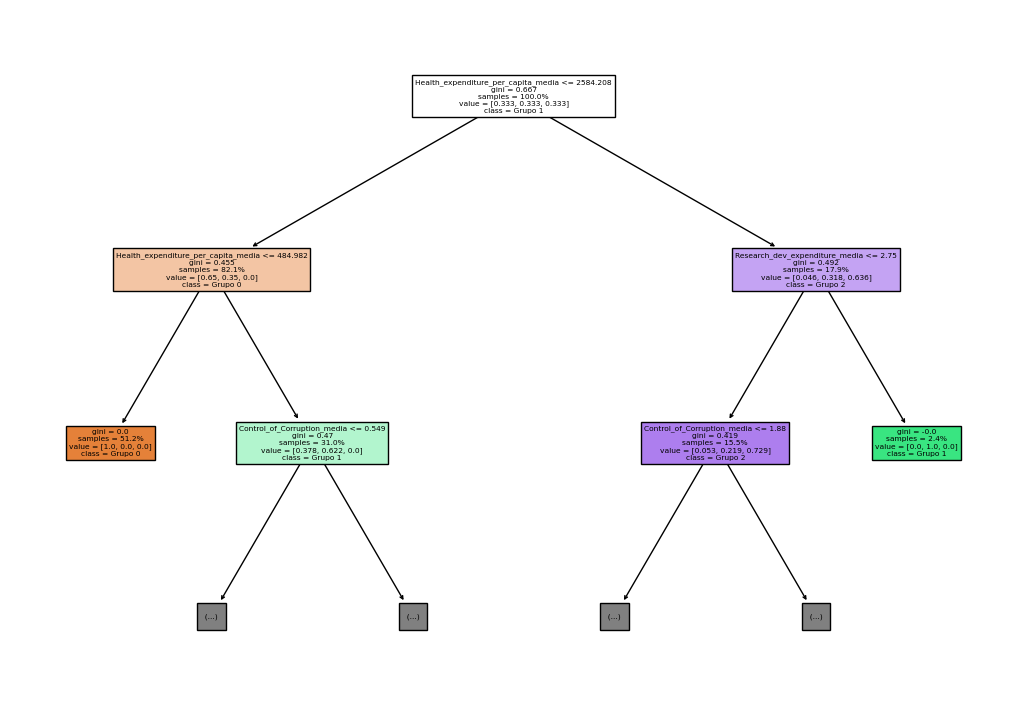

In [94]:
visualizar_arbol(
	model_cv.best_estimator_, class_names=[f"Grupo {i}" for i in range(3)],
	feature_names=X_train.columns.to_list(), max_depth=2
)

Califiquemos el modelo,

In [95]:
exactitud, f1, cmatrix = calificar_modelo(X_test, y_test, model_cv)

La exactitud es de 75.86%
El valor F1 es de 0.7595


Dado los valores de exactitud y F1, el desempeño del modelo es bastante moderado. Sin embargo recordemos que los datos utilizados están bastante desbalanceados, por lo que es mejor revisar directamente la Matriz de Confusión,

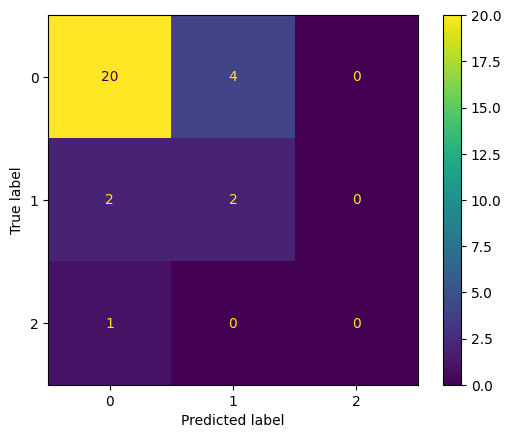

In [96]:
ConfusionMatrixDisplay(cmatrix).plot()
plt.show()

Es bastante claro que el modelo ha fallado completamente. Es bastante bueno para predecir los registros del grupo 0, pero no ha logrado ningún acierto con los otros dos grupos. Por supuesto, esto se debe a que los datos de prueba están muy sesgados al grupo 0, por lo que es un resultado inevitable para las condiciones implementadas.

#### Categoría 2

Es turno de la Categoría 2, sigamos con el tratamiento de datos y la creación del modelo,

In [97]:
X = df_cat[2][indicadores_2]
y = df_cat[2][categorias[2]]

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.25, stratify=y, random_state=42
)

del X, y

In [98]:
model_cv = cross_validation_dtc(X_train, y_train)
model_cv.best_params_

{'min_samples_split': 16,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 7}

In [99]:
model_cv.best_estimator_.get_depth()

4

Serán 15 la profundidad máxima que se ha considerado óptima para el modelo, y el modelo usa 7. En este caso nos saltaremos la visualización del diagrama de árbol e iremos directo a la evaluación,

In [100]:
exactitud, f1, cmatrix = calificar_modelo(X_test, y_test, model_cv)

La exactitud es de 44.44%
El valor F1 es de 0.445


En este caso los valores de exactitude y F1 nos indica que el rendimiento es bastante bueno. Recordemos que esta es la única categoría en la que la distribución de los datos es bastante balanceada, por lo que estos números son suficientes para dar una evaluación efectiva. No obstante, veamos la Matriz de confusión,

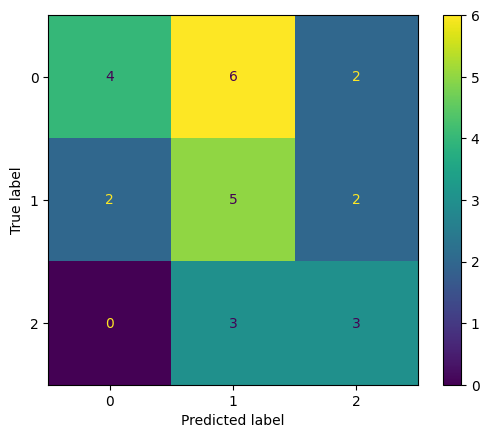

In [101]:
ConfusionMatrixDisplay(cmatrix).plot()
plt.show()

La matriz de confusión muestra un buen equilibrio entre las predicciones acertadas, y las erróneas. Por supuesto, el punto es que los aciertos sean mayores que los errores, lo que es el caso aquí. Por ende, este modelo se puede considerar como aceptable.

Dado que el objetivo de este proyecto es averiguar los patrones entre los parámetros olímpicos y los indicadores externos, miremos como influyeron estos últimos en este modelo. Dado que es un modelo aceptable, hacer este análisis aquí nos daría un buen panorama,

In [102]:
feature_importances = model_cv.best_estimator_.feature_importances_

pd.DataFrame({
	"Indicador" : X_train.columns,
	"Importancia" : feature_importances
}).sort_values(by='Importancia', ascending=False)

,Indicador,Importancia
3,Cause_of_death_by_media,0.508440
9,Research_dev_expenditure_media,0.226437
7,Prevalence_of_undernourishment_media,0.169350
10,Vulnerable_employment_media,0.069675
1,Access_to_electricity_media,0.019728
0,latitude,0.006370
2,AFFVA_media,0.000000
4,Control_of_Corruption_media,0.000000
5,GDP_per_capita_media,0.000000
6,Health_expenditure_per_capita_media,0.000000


En la tabla anterior se muestran los indicadores utilizados para este modelo ordenados por nivel de importancia que tuve en el modelo. Como podemos ver, `Research_dev_expenditure_media` tuvo la mayor influencia en el proceso de decisión, seguida de los siguientes co un valor considerable,
 * `GDP_per_capita_media`
 * `Prevalence_of_undernourishment_media`
 * `Cause_of_death_by_media`

Recordando que la Categoría 2 se refiere al *número de participaciones en los JJ.OO. de Invierno*, podemos decir que existe una gran relación con el gasto público en investigación y desarrollo. A esto le sigue indicadores que miden niveles de desarrollo económico (PIB) y social (nivel de desnutrición). 

Cabe destacar que existen otros indicadores que no tuvieron un peso significativo, como `AFFVA_media` y `Vulnerable_employment_media`. El primero es un indicador relacionado al desarrollo del sector Agricola, y el segundo al nivel de desempleo. Un siguiente paso para intentar mejorar el modelo sería realizar otro sin tener en cuenta este par de indicadores, sin embargo, nos detendremos aquí.

#### Categoría 3

Y para culminar el modelaje usando árboles de decisión, vamos a crear el modelo para la Categoría 3,

In [103]:
X = df_cat[3][indicadores_3]
y = df_cat[3][categorias[3]]

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.25, stratify=y, random_state=42
)

del X, y

In [104]:
model_cv = cross_validation_dtc(X_train, y_train)
model_cv.best_params_

{'min_samples_split': 18,
 'min_samples_leaf': 3,
 'max_features': None,
 'max_depth': 9}

In [105]:
model_cv.best_estimator_.get_depth()

2

Para esta categoría, el modelo usó solamente 9 niveles máximos, de los cuales solo usó 2. Dado que esta categoría es la única binaria, vale la pena echar un vistazo a una parte del diagrama de árbol, 

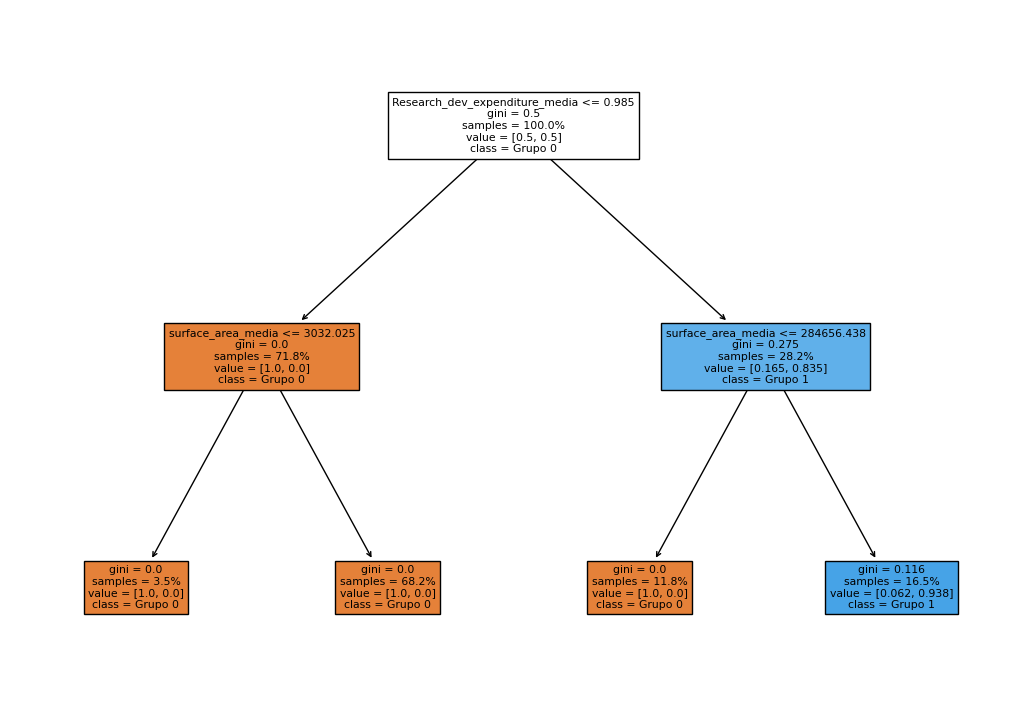

In [106]:
visualizar_arbol(
	model_cv.best_estimator_, class_names=[f"Grupo {i}" for i in range(2)],
	feature_names=X_train.columns.to_list()
)

Este modelo fue entrenado nuevamente por una categoría desbalanceada, lo que es bastante evidente al observar el diagrama de árbol. Califiquemos el modelo

In [107]:
exactitud, f1, cmatrix = calificar_modelo(X_test, y_test, model_cv, f1_average="binary")

La exactitud es de 89.66%
El valor F1 es de 0.0


La exactitud no es relevante en casos de desbalance, pero podemos ver que F1 es igual a 0. Esto indica que el modelo ha fallado completamente. Miremos la Matriz de confusión, 

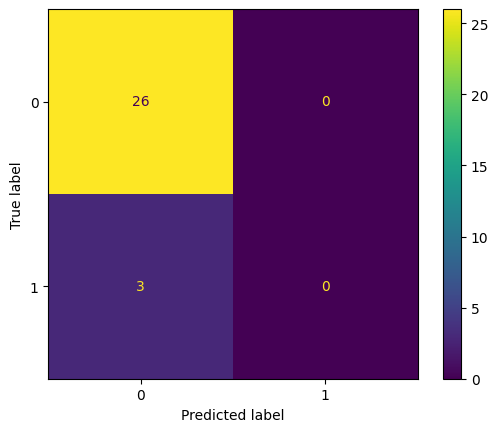

In [108]:
ConfusionMatrixDisplay(cmatrix).plot()
plt.show()

El modelo no ha dado ninguna predicción para el grupo 1, y está completamente sesgada al grupo 0. El desbalace es tan extremo que los datos son inviables para la obtención de un modelo eficiente.

## Conclusiones

El presente proyecto ha concluido, y lamentablemente no ha logrado resultados satisfactorios. El objetivo que se buscaba era encontrar patrones entre los parámetros olímpicos,

In [109]:
num_summer + medals_summer + num_winter + medals_winter

['Num_Summer',
 'gold_summer',
 'silver_summer',
 'bronze_summer',
 'Num_Winter',
 'gold_winter',
 'silver_winter',
 'bronze_winter']

Y algunos indicadores de factores externos, y ajenos a la actividad olímpica, de cada país,

In [110]:
indicadores

['latitude',
 'Access_to_electricity_media',
 'AFFVA_media',
 'Cause_of_death_by_media',
 'Control_of_Corruption_media',
 'Expenditure_on_education_media',
 'GDP_per_capita_media',
 'Health_expenditure_per_capita_media',
 'Prevalence_of_undernourishment_media',
 'Primary_completion_rate_media',
 'population_media',
 'Research_dev_expenditure_media',
 'surface_area_media',
 'Vulnerable_employment_media']

Sin embargo, este proyecto sirvió como recordatorio de lo importante que es el balance de los datos para el desarrollo óptimo de los modelos de *Machine Learning*.

No obstante, no fue el único obstáculo que enfrentó el proyecto: La elección de los indicadores externos fue insuficiente e incorrecta. Las clases obtenidas para el ejercicio no lograron ser óptimas para una clasificación eficiente usando dichos indicadores, lo que dió como resultado modelos ineficientes. Solo en una ocasión, en la Categoría 2, logramos un resultado aceptable.

Por supuesto, el trabajo de análisis de datos usando *Machine Learning* es mucho más extenso, y se aplican una serie de técnicas diversas para solventar los problemas que pueden presentarse. Algunas de las técnicas que pudieron usarse en este proyecto son las siguientes, 

 * Para el desbalance de los datos:
   * Disminuir el número de muestras en la clase mayoritaria borrando registros: Undersampling.
   * Creando registros sintéticos de las clases minoritarias usando técnicas como SMOTE o ADASYN: Oversampling.
   * Usar un modelo de clasificación con un mejor rendimiento en el desbalance como *Random Forest* o *Gradient Boosting*.
 * Para los indicadores: Hacer más pruebas con una mayor variedad de factores externos.
 * Para tratar con los valores nulos: Imputación de datos en lugar de eliminarlos usando interpolación o el algoritmo de *K-Nearest Neighbors* para mantener el volumen máximo de datos.

Por supuesto, cada alternativa tiene sus pros y sus contras, sin embargo, la esencia de este proyecto fue mantener el análisis lo más simple posible.